In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from scipy.optimize import minimize
import time

In [2]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [3]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [4]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [5]:
# 予測と最適化を行う関数
def predict_optimize_BFGS(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


# 予測と最適化を行う関数
def predict_optimize_SLSQP(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="slsqp",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


# 予測と最適化を行う関数
def predict_optimize_Neldar(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="Nelder-Mead",
        options={"adaptive": True},
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [6]:
def sales_optimize_BFGS(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
) -> tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


def sales_optimize_SLSQP(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
) -> tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="SLSQP",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


def sales_optimize_Neldar(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
) -> tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="Nelder-Mead",
        options={"adaptive": True},
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [7]:
# CVを行う関数
def cross_validation_BFGS(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="BFGS",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


# CVを行う関数
def cross_validation_SLSQP(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


# CVを行う関数
def cross_validation_Neldar(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="Nelder-Mead",
            options={"adaptive": True},
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [8]:
def second_objective_single(price, target, intercepts, coefs, M):
    return (
        target
        - sum(
            price[m]
            * (intercepts[m] + sum(coefs[m][m_prime] * price[m_prime] for m_prime in range(M)))
            for m in range(M)
        )
    ) ** 2

In [9]:
def second_objective_multi(prices, target, intercepts_list, coefs_list, M, K):
    obj_list = []
    for k in range(K):
        intercepts = intercepts_list[k]
        coefs = coefs_list[k]
        # 予測販売量の計算
        quantity_hat = intercepts + np.dot(coefs, prices)
        # 売上の計算
        revenue = np.dot(prices, quantity_hat)
        obj_list.append(revenue)
    # 平均売上の計算
    obj = np.mean(obj_list)
    return (target - obj) ** 2

In [10]:
# CVを行う関数
def twostage_single_BFGS(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
):
    start = time.time()
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    cv_optimal_sales = np.mean(optimal_sales_list)

    # 2段階目の最適化

    lr_second = MultiOutputRegressor(LinearRegression())
    lr_second.fit(X, y)
    # 係数と切片を取得
    coefs_2 = [estimate.coef_ for estimate in lr_second.estimators_]
    intercepts_2 = [estimate.intercept_ for estimate in lr_second.estimators_]

    result_2 = minimize(
        second_objective_single,
        initial_prices,
        args=(cv_optimal_sales, intercepts_2, coefs_2, M),
        bounds=bounds,
        method="L-BFGS-B",
    )

    optimal_prices_2 = result_2.x

    end = time.time()
    run_time = end - start

    return optimal_prices_2, cv_optimal_sales, run_time

In [11]:
# CVを行う関数
def twostage_single_SLSQP(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
):
    start = time.time()
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    cv_optimal_sales = np.mean(optimal_sales_list)

    # 2段階目の最適化

    lr_second = MultiOutputRegressor(LinearRegression())
    lr_second.fit(X, y)
    # 係数と切片を取得
    coefs_2 = [estimate.coef_ for estimate in lr_second.estimators_]
    intercepts_2 = [estimate.intercept_ for estimate in lr_second.estimators_]

    result_2 = minimize(
        second_objective_single,
        initial_prices,
        args=(cv_optimal_sales, intercepts_2, coefs_2, M),
        bounds=bounds,
        method="SLSQP",
    )

    optimal_prices_2 = result_2.x

    end = time.time()
    run_time = end - start

    return optimal_prices_2, cv_optimal_sales, run_time

In [12]:
# CVを行う関数
def twostage_single_Neldar(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
):
    start = time.time()
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    cv_optimal_sales = np.mean(optimal_sales_list)

    # 2段階目の最適化

    lr_second = MultiOutputRegressor(LinearRegression())
    lr_second.fit(X, y)
    # 係数と切片を取得
    coefs_2 = [estimate.coef_ for estimate in lr_second.estimators_]
    intercepts_2 = [estimate.intercept_ for estimate in lr_second.estimators_]

    result_2 = minimize(
        second_objective_single,
        initial_prices,
        args=(cv_optimal_sales, intercepts_2, coefs_2, M),
        bounds=bounds,
        method="Nelder-Mead",
        options={"adaptive": True},
    )

    optimal_prices_2 = result_2.x

    end = time.time()
    run_time = end - start

    return optimal_prices_2, cv_optimal_sales, run_time

In [13]:
# CVを行う関数
def twostage_multi_BFGS(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    intercepts_list = []
    coefs_list = []

    start = time.time()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        intercepts_list.append(intercepts)
        coefs_list.append(coefs)

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    cv_optimal_sales = np.mean(optimal_sales_list)

    # 2段階目の最適化

    result_2 = minimize(
        second_objective_multi,
        initial_prices,
        args=(cv_optimal_sales, intercepts_list, coefs_list, M, K),
        bounds=bounds,
        method="L-BFGS-B",
    )

    optimal_prices_2 = result_2.x

    # 関数の実行時間を計測

    end = time.time()

    run_time = end - start

    return optimal_prices_2, cv_optimal_sales, run_time

In [14]:
# CVを行う関数
def twostage_multi_SLSQP(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    intercepts_list = []
    coefs_list = []

    start = time.time()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        intercepts_list.append(intercepts)
        coefs_list.append(coefs)

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    cv_optimal_sales = np.mean(optimal_sales_list)

    # 2段階目の最適化

    result_2 = minimize(
        second_objective_multi,
        initial_prices,
        args=(cv_optimal_sales, intercepts_list, coefs_list, M, K),
        bounds=bounds,
        method="SLSQP",
    )

    optimal_prices_2 = result_2.x

    # 関数の実行時間を計測

    end = time.time()

    run_time = end - start

    return optimal_prices_2, cv_optimal_sales, run_time

In [15]:
# CVを行う関数
def twostage_multi_Neldar(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    intercepts_list = []
    coefs_list = []

    start = time.time()

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        intercepts_list.append(intercepts)
        coefs_list.append(coefs)

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    cv_optimal_sales = np.mean(optimal_sales_list)

    # 2段階目の最適化

    result_2 = minimize(
        second_objective_multi,
        initial_prices,
        args=(cv_optimal_sales, intercepts_list, coefs_list, M, K),
        bounds=bounds,
        method="Nelder-Mead",
        options={"adaptive": True},
    )

    optimal_prices_2 = result_2.x

    # 関数の実行時間を計測

    end = time.time()

    run_time = end - start

    return optimal_prices_2, cv_optimal_sales, run_time

In [16]:
# M =10 で100回実験

# 結果を格納するリスト
predict_optimize_BFGS_value_list_10 = []

predict_optimize_SLSQP_value_list_10 = []

predict_optimize_Neldar_value_list_10 = []

sales_optimize_BFGS_value_list_10 = []

sales_optimize_SLSQP_value_list_10 = []

sales_optimize_Neldar_value_list_10 = []

po_prices_BFGS_list_10 = []
po_prices_SLSQP_list_10 = []
po_prices_Neldar_list_10 = []

twostage_single_BFGS_value_list_10 = []
twostage_single_BFGS_runtime_list_10 = []

twostage_single_SLSQP_value_list_10 = []
twostage_single_SLSQP_runtime_list_10 = []

twostage_single_Neldar_value_list_10 = []
twostage_single_Neldar_runtime_list_10 = []

ts_BFGS_list_10 = []
ts_SLSQP_list_10 = []
ts_Neldar_list_10 = []

twostage_multi_BFGS_value_list_10 = []
twostage_multi_BFGS_runtime_list_10 = []

twostage_multi_SLSQP_value_list_10 = []
twostage_multi_SLSQP_runtime_list_10 = []

twostage_multi_Neldar_value_list_10 = []
twostage_multi_Neldar_runtime_list_10 = []

tm_BFGS_list_10 = []
tm_SLSQP_list_10 = []
tm_Neldar_list_10 = []

M = 10
K = 5
for i in range(100):
    # データの生成
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    r_m = 0.6
    r_M = 1.0

    prices_list = []
    quantity_list = []

    for _ in range(500):
        prices = create_price(r_m, r_M, M)
        prices_list.append(prices)
        quantity = quantity_function(prices, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(prices_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # 予測と最適化を行う関数
    predict_optimize_BFGS_value, predict_optimize_BFGS_prices = predict_optimize_BFGS(M, X, y, z)
    predict_optimize_SLSQP_value, predict_optimize_SLSQP_prices = predict_optimize_SLSQP(
        M, X, y, z
    )
    predict_optimize_Neldar_value, predict_optimize_Neldar_prices = predict_optimize_Neldar(
        M, X, y, z
    )

    # 販売と最適化を行う関数
    sales_optimize_BFGS_value, sales_optimize_BFGS_prices = sales_optimize_BFGS(M, alpha, beta, z)
    sales_optimize_SLSQP_value, sales_optimize_SLSQP_prices = sales_optimize_SLSQP(
        M, alpha, beta, z
    )
    sales_optimize_Neldar_value, sales_optimize_Neldar_prices = sales_optimize_Neldar(
        M, alpha, beta, z
    )

    # 予測と最適化を行った価格をsales_functionに代入
    po_prices_BFGS = sum(sales_function(predict_optimize_BFGS_prices, alpha, beta))
    po_prices_SLSQP = sum(sales_function(predict_optimize_SLSQP_prices, alpha, beta))
    po_prices_Neldar = sum(sales_function(predict_optimize_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(single)
    twostage_single_BFGS_prices, twostage_single_BFGS_value, twostage_single_BFGS_runtime = (
        twostage_single_BFGS(X, y, M, K, z)
    )
    twostage_single_SLSQP_prices, twostage_single_SLSQP_value, twostage_single_SLSQP_runtime = (
        twostage_single_SLSQP(X, y, M, K, z)
    )
    twostage_single_Neldar_prices, twostage_single_Neldar_value, twostage_single_Neldar_runtime = (
        twostage_single_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    ts_BFGS = sum(sales_function(twostage_single_BFGS_prices, alpha, beta))
    ts_SLSQP = sum(sales_function(twostage_single_SLSQP_prices, alpha, beta))
    ts_Neldar = sum(sales_function(twostage_single_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(multi)
    twostage_multi_BFGS_prices, twostage_multi_BFGS_value, twostage_multi_BFGS_runtime = (
        twostage_multi_BFGS(X, y, M, K, z)
    )
    twostage_multi_SLSQP_prices, twostage_multi_SLSQP_value, twostage_multi_SLSQP_runtime = (
        twostage_multi_SLSQP(X, y, M, K, z)
    )
    twostage_multi_Neldar_prices, twostage_multi_Neldar_value, twostage_multi_Neldar_runtime = (
        twostage_multi_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    tm_BFGS = sum(sales_function(twostage_multi_BFGS_prices, alpha, beta))
    tm_SLSQP = sum(sales_function(twostage_multi_SLSQP_prices, alpha, beta))
    tm_Neldar = sum(sales_function(twostage_multi_Neldar_prices, alpha, beta))

    # 結果を格納
    predict_optimize_BFGS_value_list_10.append(
        predict_optimize_BFGS_value / sales_optimize_BFGS_value
    )

    predict_optimize_SLSQP_value_list_10.append(
        predict_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    predict_optimize_Neldar_value_list_10.append(
        predict_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    sales_optimize_BFGS_value_list_10.append(sales_optimize_BFGS_value / sales_optimize_BFGS_value)

    sales_optimize_SLSQP_value_list_10.append(
        sales_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    sales_optimize_Neldar_value_list_10.append(
        sales_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    po_prices_BFGS_list_10.append(po_prices_BFGS / sales_optimize_BFGS_value)

    po_prices_SLSQP_list_10.append(po_prices_SLSQP / sales_optimize_SLSQP_value)

    po_prices_Neldar_list_10.append(po_prices_Neldar / sales_optimize_Neldar_value)

    twostage_single_BFGS_value_list_10.append(
        twostage_single_BFGS_value / sales_optimize_BFGS_value
    )

    twostage_single_BFGS_runtime_list_10.append(twostage_single_BFGS_runtime)

    twostage_single_SLSQP_value_list_10.append(
        twostage_single_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_single_SLSQP_runtime_list_10.append(twostage_single_SLSQP_runtime)

    twostage_single_Neldar_value_list_10.append(
        twostage_single_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_single_Neldar_runtime_list_10.append(twostage_single_Neldar_runtime)

    ts_BFGS_list_10.append(ts_BFGS / sales_optimize_BFGS_value)

    ts_SLSQP_list_10.append(ts_SLSQP / sales_optimize_SLSQP_value)

    ts_Neldar_list_10.append(ts_Neldar / sales_optimize_Neldar_value)

    twostage_multi_BFGS_value_list_10.append(twostage_multi_BFGS_value / sales_optimize_BFGS_value)

    twostage_multi_BFGS_runtime_list_10.append(twostage_multi_BFGS_runtime)

    twostage_multi_SLSQP_value_list_10.append(
        twostage_multi_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_multi_SLSQP_runtime_list_10.append(twostage_multi_SLSQP_runtime)

    twostage_multi_Neldar_value_list_10.append(
        twostage_multi_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_multi_Neldar_runtime_list_10.append(twostage_multi_Neldar_runtime)

    tm_BFGS_list_10.append(tm_BFGS / sales_optimize_BFGS_value)

    tm_Neldar_list_10.append(tm_Neldar / sales_optimize_Neldar_value)

    tm_SLSQP_list_10.append(tm_SLSQP / sales_optimize_SLSQP_value)

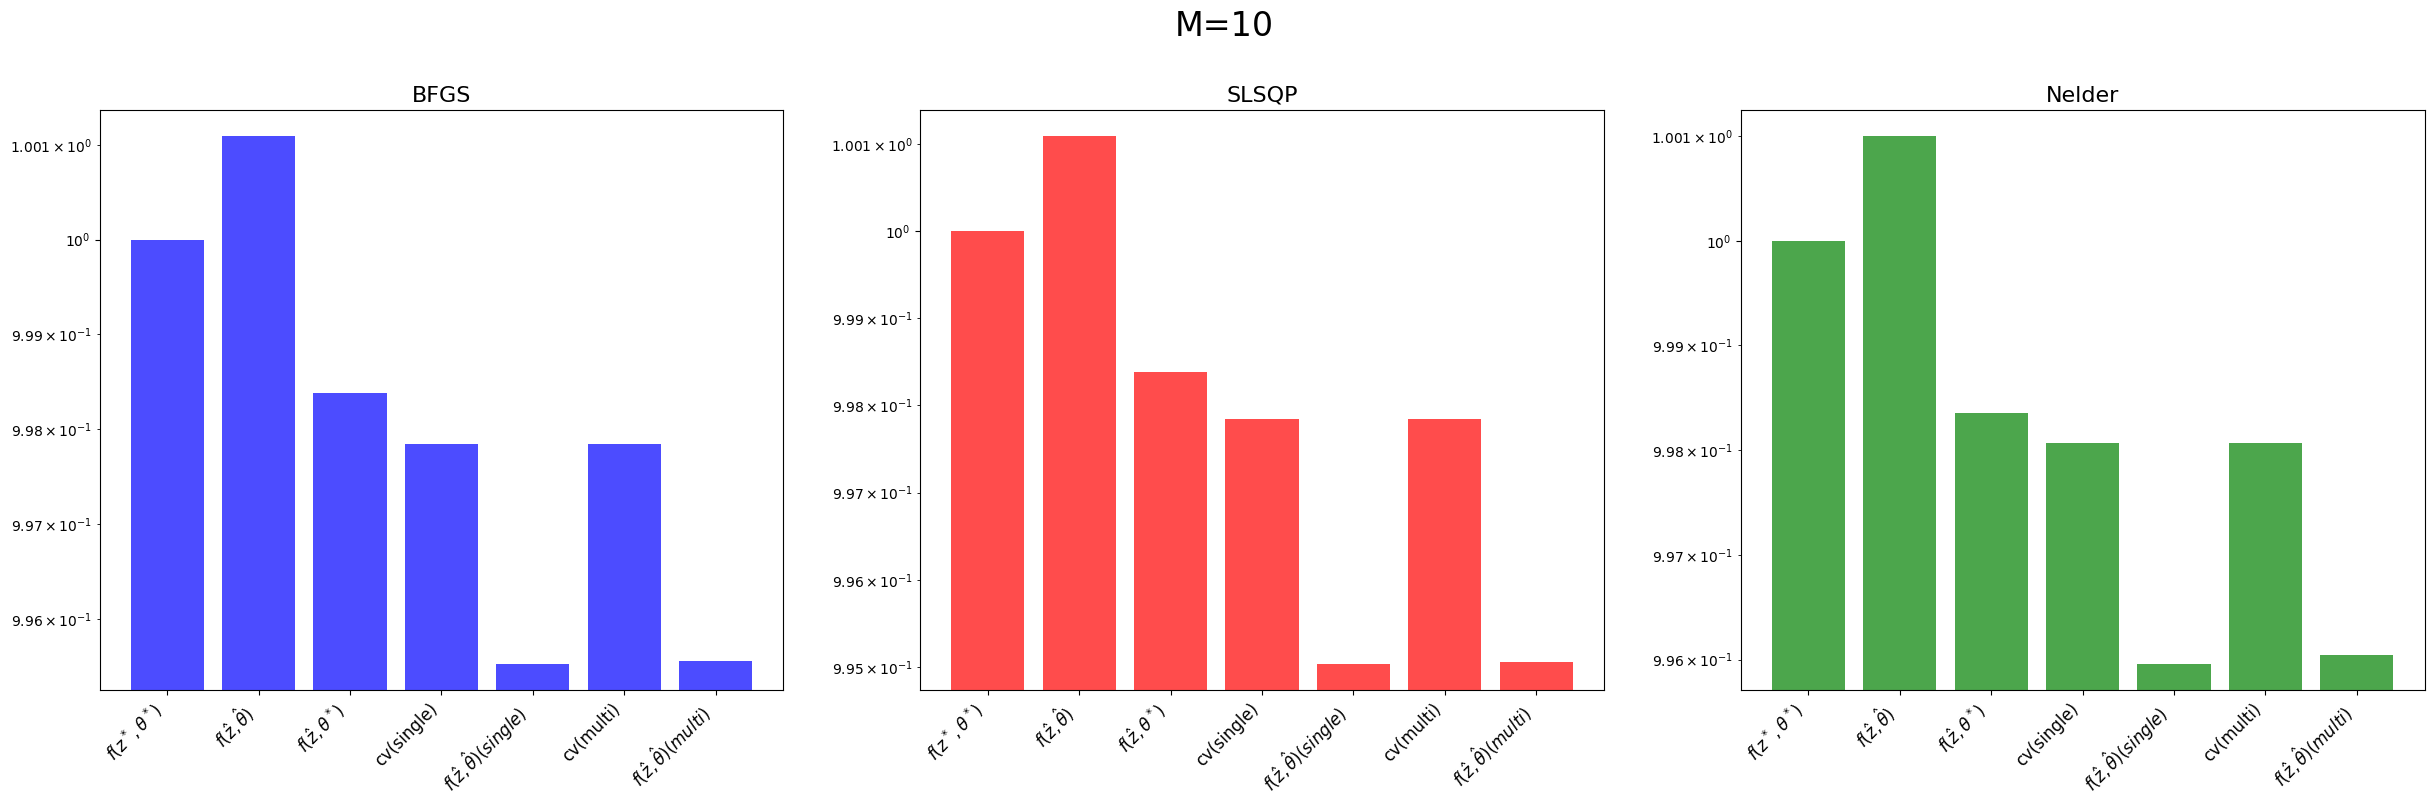

In [17]:
# BFGS
predict_optimize_BFGS_value_list_10 = np.mean(predict_optimize_BFGS_value_list_10)
sales_optimize_BFGS_value_list_10 = np.mean(sales_optimize_BFGS_value_list_10)
po_prices_BFGS_list_10 = np.mean(po_prices_BFGS_list_10)
twostage_single_BFGS_value_list_10 = np.mean(twostage_single_BFGS_value_list_10)
ts_BFGS_list_10 = np.mean(ts_BFGS_list_10)
twostage_multi_BFGS_value_list_10 = np.mean(twostage_multi_BFGS_value_list_10)
tm_BFGS_list_10 = np.mean(tm_BFGS_list_10)

# SLSQP
predict_optimize_SLSQP_value_list_10 = np.mean(predict_optimize_SLSQP_value_list_10)
sales_optimize_SLSQP_value_list_10 = np.mean(sales_optimize_SLSQP_value_list_10)
po_prices_SLSQP_list_10 = np.mean(po_prices_SLSQP_list_10)
twostage_single_SLSQP_value_list_10 = np.mean(twostage_single_SLSQP_value_list_10)
ts_SLSQP_list_10 = np.mean(ts_SLSQP_list_10)
twostage_multi_SLSQP_value_list_10 = np.mean(twostage_multi_SLSQP_value_list_10)
tm_SLSQP_list_10 = np.mean(tm_SLSQP_list_10)

# Neldar
predict_optimize_Neldar_value_list_10 = np.mean(predict_optimize_Neldar_value_list_10)
sales_optimize_Neldar_value_list_10 = np.mean(sales_optimize_Neldar_value_list_10)
po_prices_Neldar_list_10 = np.mean(po_prices_Neldar_list_10)
twostage_single_Neldar_value_list_10 = np.mean(twostage_single_Neldar_value_list_10)
ts_Neldar_list_10 = np.mean(ts_Neldar_list_10)
twostage_multi_Neldar_value_list_10 = np.mean(twostage_multi_Neldar_value_list_10)
tm_Neldar_list_10 = np.mean(tm_Neldar_list_10)

# 結果のリスト
result_BFGS_list_10 = [
    sales_optimize_BFGS_value_list_10,
    predict_optimize_BFGS_value_list_10,
    po_prices_BFGS_list_10,
    twostage_single_BFGS_value_list_10,
    ts_BFGS_list_10,
    twostage_multi_BFGS_value_list_10,
    tm_BFGS_list_10,
]

result_SLSQP_list_10 = [
    sales_optimize_SLSQP_value_list_10,
    predict_optimize_SLSQP_value_list_10,
    po_prices_SLSQP_list_10,
    twostage_single_SLSQP_value_list_10,
    ts_SLSQP_list_10,
    twostage_multi_SLSQP_value_list_10,
    tm_SLSQP_list_10,
]

result_Neldar_list_10 = [
    sales_optimize_Neldar_value_list_10,
    predict_optimize_Neldar_value_list_10,
    po_prices_Neldar_list_10,
    twostage_single_Neldar_value_list_10,
    ts_Neldar_list_10,
    twostage_multi_Neldar_value_list_10,
    tm_Neldar_list_10,
]

# ラベルの作成
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat{\theta})$",
    r"$f(\hat{z},\theta^*)$",
    "cv(single)",
    r"$f(\hat{z},\hat{\theta})(single)$",
    "cv(multi)",
    r"$f(\hat{z},\hat{\theta})(multi)$",
]


# x軸の位置を設定
x = np.arange(len(labels))  # 0から6までの整数

# 3つのサブプロットを持つ図を作成
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# 図全体のタイトルを設定
plt.suptitle("M=10", fontsize=24)

# BFGSの結果をプロット
axs[0].bar(x, result_BFGS_list_10, color="blue", alpha=0.7)
axs[0].set_title("BFGS", fontsize=16)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[0].set_yscale("log")

# SLSQPの結果をプロット
axs[1].bar(x, result_SLSQP_list_10, color="red", alpha=0.7)
axs[1].set_title("SLSQP", fontsize=16)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[1].set_yscale("log")

# Nelderの結果をプロット
axs[2].bar(x, result_Neldar_list_10, color="green", alpha=0.7)
axs[2].set_title("Nelder", fontsize=16)
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[2].set_yscale("log")

# レイアウトの調整
plt.subplots_adjust(bottom=0.3)  # 下部マージンを広げる

# グラフを表示
plt.show()

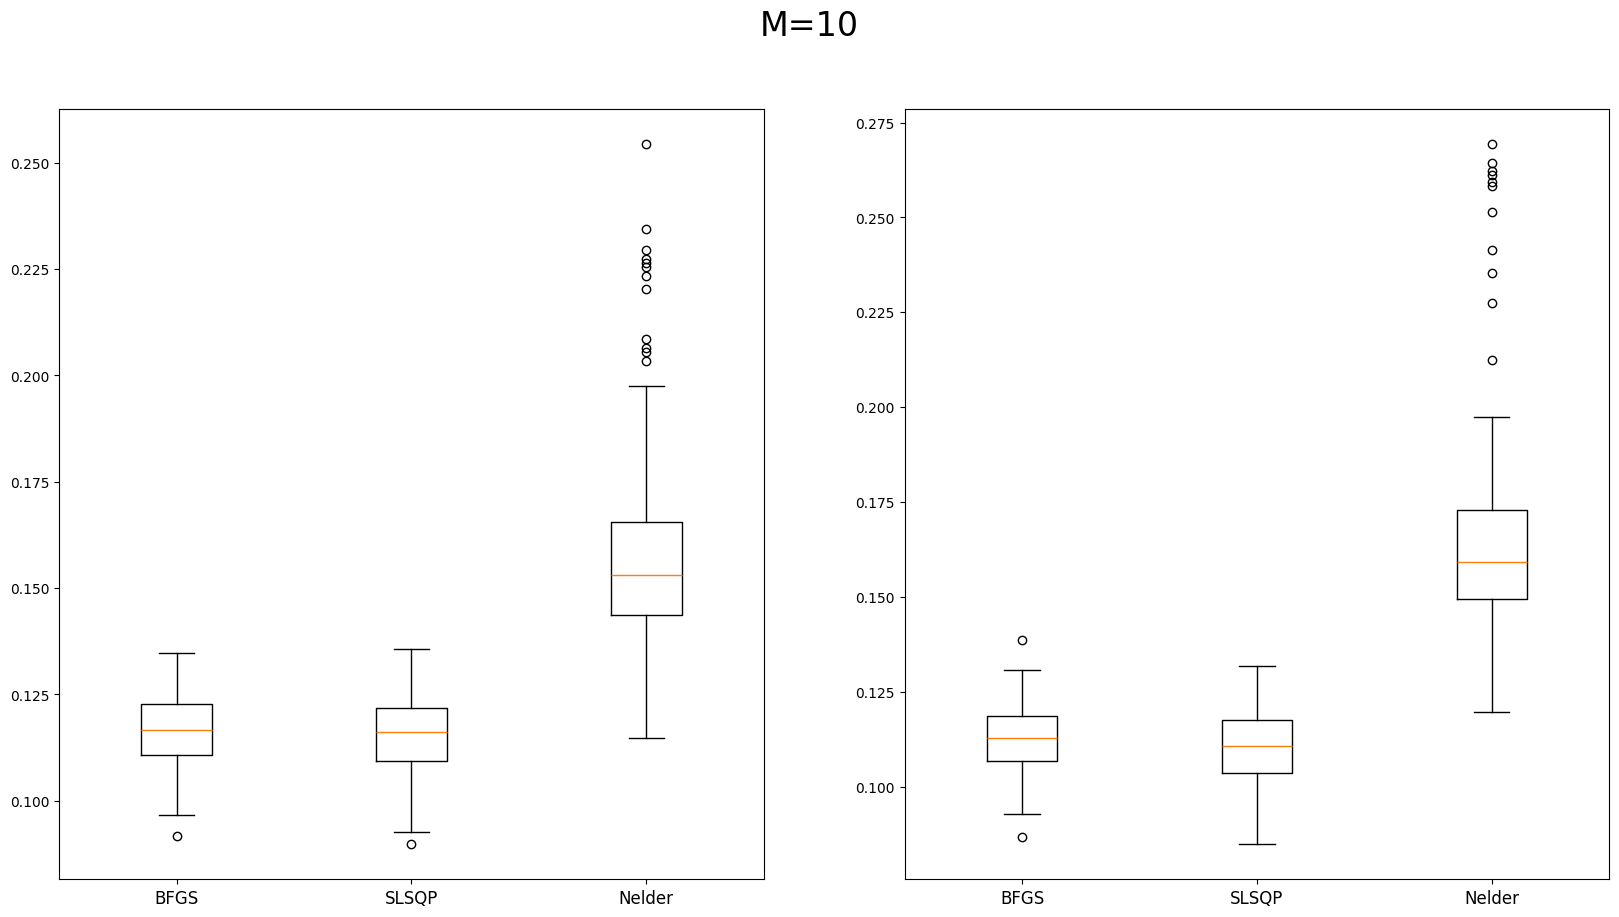

In [18]:
# run_timeを箱ひげ図でプロット
run_time_list_10_single = [
    twostage_single_BFGS_runtime_list_10,
    twostage_single_SLSQP_runtime_list_10,
    twostage_single_Neldar_runtime_list_10,
]

run_time_list_10_multi = [
    twostage_multi_BFGS_runtime_list_10,
    twostage_multi_SLSQP_runtime_list_10,
    twostage_multi_Neldar_runtime_list_10,
]

# グラフの作成
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 図全体のタイトルを設定
plt.suptitle("M=10", fontsize=24)

# 1つ目のグラフ
axs[0].boxplot(run_time_list_10_single)
axs[0].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# 2つ目のグラフ
axs[1].boxplot(run_time_list_10_multi)
axs[1].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# グラフの表示
plt.show()


In [19]:
# run_timeの平均を計算
run_time_list_10_single = [
    np.mean(twostage_single_BFGS_runtime_list_10),
    np.mean(twostage_single_SLSQP_runtime_list_10),
    np.mean(twostage_single_Neldar_runtime_list_10),
]

run_time_list_10_multi = [
    np.mean(twostage_multi_BFGS_runtime_list_10),
    np.mean(twostage_multi_SLSQP_runtime_list_10),
    np.mean(twostage_multi_Neldar_runtime_list_10),
]
# すべての結果をcsvファイルに保存
result_list_10 = (
    result_BFGS_list_10
    + result_SLSQP_list_10
    + result_Neldar_list_10
    + run_time_list_10_single
    + run_time_list_10_multi
)

result_list_10 = pd.DataFrame(result_list_10)
result_list_10.to_csv("result_list_10.csv")  # csvファイルに保存


In [20]:
# M = 20 で100回実験

# 結果を格納するリスト
predict_optimize_BFGS_value_list_20 = []

predict_optimize_SLSQP_value_list_20 = []

predict_optimize_Neldar_value_list_20 = []

sales_optimize_BFGS_value_list_20 = []

sales_optimize_SLSQP_value_list_20 = []

sales_optimize_Neldar_value_list_20 = []

po_prices_BFGS_list_20 = []
po_prices_SLSQP_list_20 = []
po_prices_Neldar_list_20 = []

twostage_single_BFGS_value_list_20 = []
twostage_single_BFGS_runtime_list_20 = []

twostage_single_SLSQP_value_list_20 = []
twostage_single_SLSQP_runtime_list_20 = []

twostage_single_Neldar_value_list_20 = []
twostage_single_Neldar_runtime_list_20 = []

ts_BFGS_list_20 = []
ts_SLSQP_list_20 = []
ts_Neldar_list_20 = []

twostage_multi_BFGS_value_list_20 = []
twostage_multi_BFGS_runtime_list_20 = []

twostage_multi_SLSQP_value_list_20 = []
twostage_multi_SLSQP_runtime_list_20 = []

twostage_multi_Neldar_value_list_20 = []
twostage_multi_Neldar_runtime_list_20 = []

tm_BFGS_list_20 = []
tm_SLSQP_list_20 = []
tm_Neldar_list_20 = []

M = 20
K = 5

for i in range(100):
    # データの生成
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    r_m = 0.6
    r_M = 1.0

    prices_list = []
    quantity_list = []

    for _ in range(500):
        prices = create_price(r_m, r_M, M)
        prices_list.append(prices)
        quantity = quantity_function(prices, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(prices_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # 予測と最適化を行う関数
    predict_optimize_BFGS_value, predict_optimize_BFGS_prices = predict_optimize_BFGS(M, X, y, z)
    predict_optimize_SLSQP_value, predict_optimize_SLSQP_prices = predict_optimize_SLSQP(
        M, X, y, z
    )
    predict_optimize_Neldar_value, predict_optimize_Neldar_prices = predict_optimize_Neldar(
        M, X, y, z
    )

    # 販売と最適化を行う関数
    sales_optimize_BFGS_value, sales_optimize_BFGS_prices = sales_optimize_BFGS(M, alpha, beta, z)
    sales_optimize_SLSQP_value, sales_optimize_SLSQP_prices = sales_optimize_SLSQP(
        M, alpha, beta, z
    )
    sales_optimize_Neldar_value, sales_optimize_Neldar_prices = sales_optimize_Neldar(
        M, alpha, beta, z
    )

    # 予測と最適化を行った価格をsales_functionに代入
    po_prices_BFGS = sum(sales_function(predict_optimize_BFGS_prices, alpha, beta))
    po_prices_SLSQP = sum(sales_function(predict_optimize_SLSQP_prices, alpha, beta))
    po_prices_Neldar = sum(sales_function(predict_optimize_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(single
    twostage_single_BFGS_prices, twostage_single_BFGS_value, twostage_single_BFGS_runtime = (
        twostage_single_BFGS(X, y, M, K, z)
    )
    twostage_single_SLSQP_prices, twostage_single_SLSQP_value, twostage_single_SLSQP_runtime = (
        twostage_single_SLSQP(X, y, M, K, z)
    )
    twostage_single_Neldar_prices, twostage_single_Neldar_value, twostage_single_Neldar_runtime = (
        twostage_single_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    ts_BFGS = sum(sales_function(twostage_single_BFGS_prices, alpha, beta))
    ts_SLSQP = sum(sales_function(twostage_single_SLSQP_prices, alpha, beta))
    ts_Neldar = sum(sales_function(twostage_single_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(multi)
    twostage_multi_BFGS_prices, twostage_multi_BFGS_value, twostage_multi_BFGS_runtime = (
        twostage_multi_BFGS(X, y, M, K, z)
    )
    twostage_multi_SLSQP_prices, twostage_multi_SLSQP_value, twostage_multi_SLSQP_runtime = (
        twostage_multi_SLSQP(X, y, M, K, z)
    )
    twostage_multi_Neldar_prices, twostage_multi_Neldar_value, twostage_multi_Neldar_runtime = (
        twostage_multi_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入

    tm_BFGS = sum(sales_function(twostage_multi_BFGS_prices, alpha, beta))
    tm_SLSQP = sum(sales_function(twostage_multi_SLSQP_prices, alpha, beta))
    tm_Neldar = sum(sales_function(twostage_multi_Neldar_prices, alpha, beta))

    # 結果を格納
    predict_optimize_BFGS_value_list_20.append(
        predict_optimize_BFGS_value / sales_optimize_BFGS_value
    )

    predict_optimize_SLSQP_value_list_20.append(
        predict_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    predict_optimize_Neldar_value_list_20.append(
        predict_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    sales_optimize_BFGS_value_list_20.append(sales_optimize_BFGS_value / sales_optimize_BFGS_value)

    sales_optimize_SLSQP_value_list_20.append(
        sales_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    sales_optimize_Neldar_value_list_20.append(
        sales_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    po_prices_BFGS_list_20.append(po_prices_BFGS / sales_optimize_BFGS_value)

    po_prices_SLSQP_list_20.append(po_prices_SLSQP / sales_optimize_SLSQP_value)

    po_prices_Neldar_list_20.append(po_prices_Neldar / sales_optimize_Neldar_value)

    twostage_single_BFGS_value_list_20.append(
        twostage_single_BFGS_value / sales_optimize_BFGS_value
    )

    twostage_single_BFGS_runtime_list_20.append(twostage_single_BFGS_runtime)

    twostage_single_SLSQP_value_list_20.append(
        twostage_single_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_single_SLSQP_runtime_list_20.append(twostage_single_SLSQP_runtime)

    twostage_single_Neldar_value_list_20.append(
        twostage_single_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_single_Neldar_runtime_list_20.append(twostage_single_Neldar_runtime)

    ts_BFGS_list_20.append(ts_BFGS / sales_optimize_BFGS_value)

    ts_SLSQP_list_20.append(ts_SLSQP / sales_optimize_SLSQP_value)

    ts_Neldar_list_20.append(ts_Neldar / sales_optimize_Neldar_value)

    twostage_multi_BFGS_value_list_20.append(twostage_multi_BFGS_value / sales_optimize_BFGS_value)

    twostage_multi_BFGS_runtime_list_20.append(twostage_multi_BFGS_runtime)

    twostage_multi_SLSQP_value_list_20.append(
        twostage_multi_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_multi_SLSQP_runtime_list_20.append(twostage_multi_SLSQP_runtime)

    twostage_multi_Neldar_value_list_20.append(
        twostage_multi_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_multi_Neldar_runtime_list_20.append(twostage_multi_Neldar_runtime)

    tm_BFGS_list_20.append(tm_BFGS / sales_optimize_BFGS_value)

    tm_Neldar_list_20.append(tm_Neldar / sales_optimize_Neldar_value)

    tm_SLSQP_list_20.append(tm_SLSQP / sales_optimize_SLSQP_value)


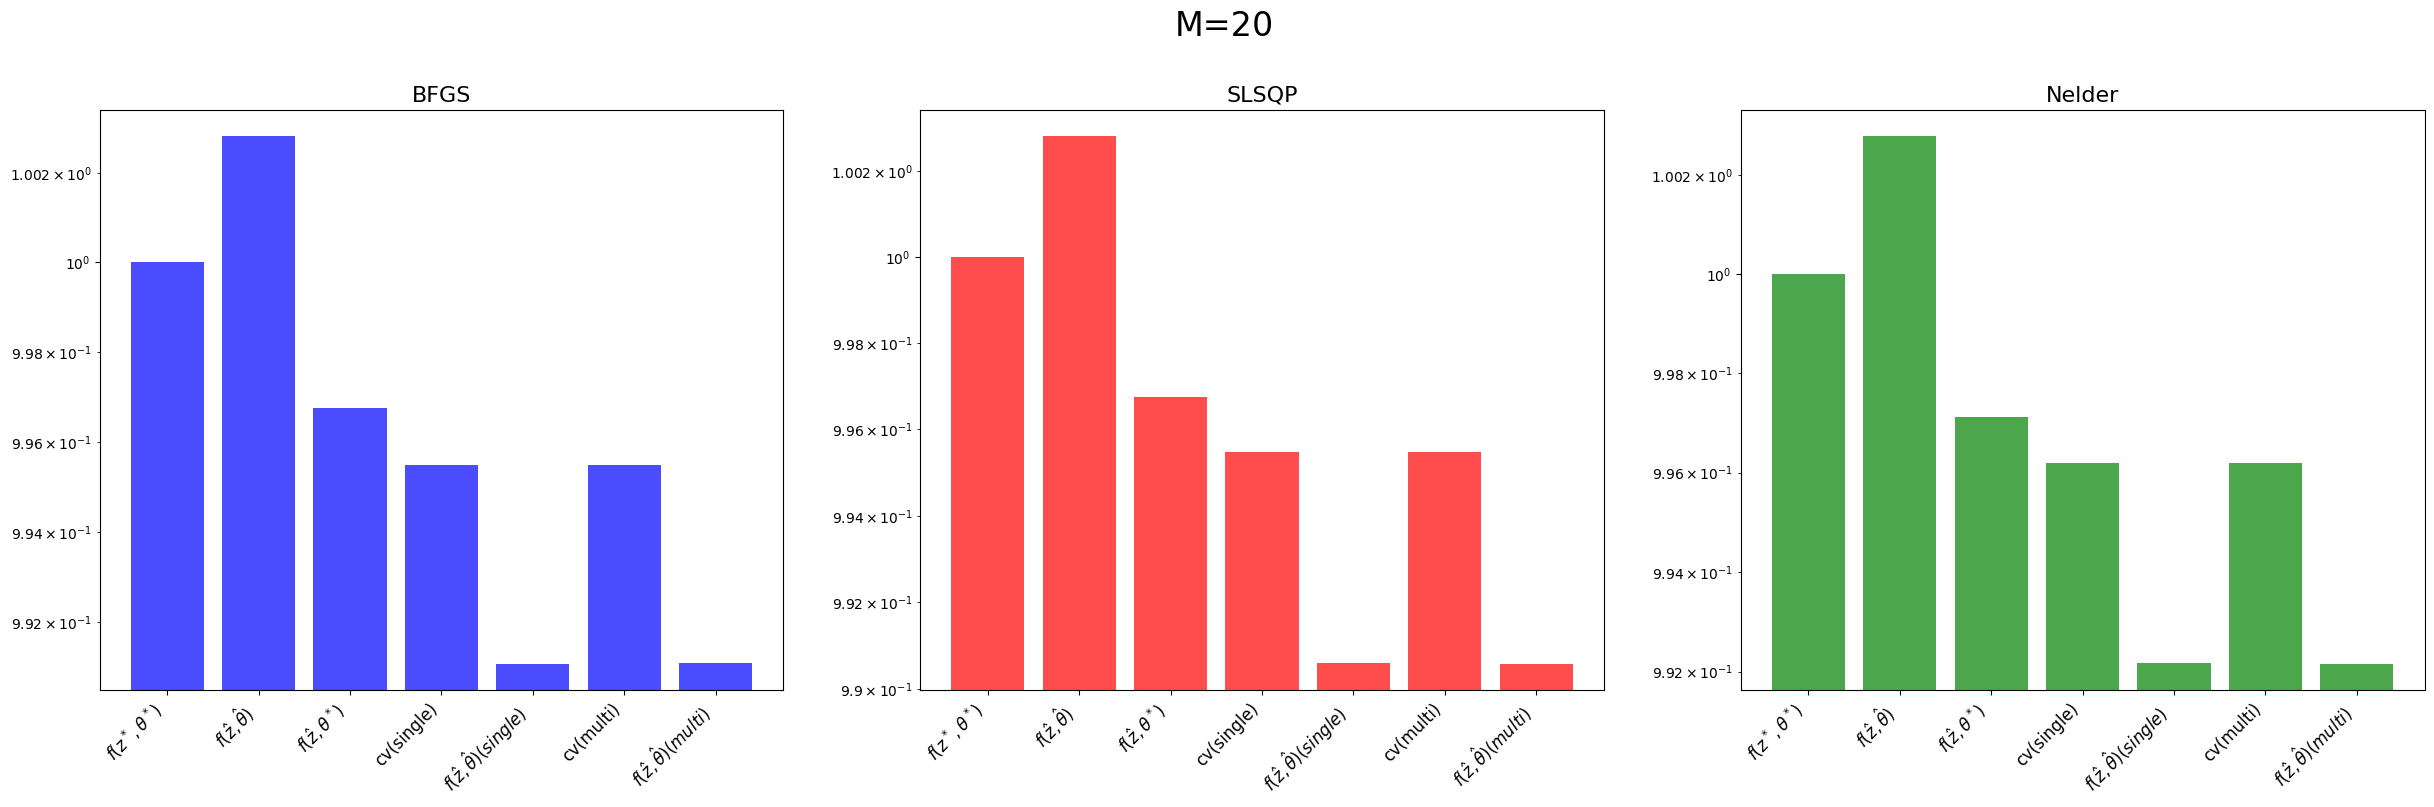

In [21]:
# BFGS
predict_optimize_BFGS_value_list_20 = np.mean(predict_optimize_BFGS_value_list_20)
sales_optimize_BFGS_value_list_20 = np.mean(sales_optimize_BFGS_value_list_20)
po_prices_BFGS_list_20 = np.mean(po_prices_BFGS_list_20)
twostage_single_BFGS_value_list_20 = np.mean(twostage_single_BFGS_value_list_20)
ts_BFGS_list_20 = np.mean(ts_BFGS_list_20)
twostage_multi_BFGS_value_list_20 = np.mean(twostage_multi_BFGS_value_list_20)
tm_BFGS_list_20 = np.mean(tm_BFGS_list_20)

# SLSQP
predict_optimize_SLSQP_value_list_20 = np.mean(predict_optimize_SLSQP_value_list_20)
sales_optimize_SLSQP_value_list_20 = np.mean(sales_optimize_SLSQP_value_list_20)
po_prices_SLSQP_list_20 = np.mean(po_prices_SLSQP_list_20)
twostage_single_SLSQP_value_list_20 = np.mean(twostage_single_SLSQP_value_list_20)
ts_SLSQP_list_20 = np.mean(ts_SLSQP_list_20)
twostage_multi_SLSQP_value_list_20 = np.mean(twostage_multi_SLSQP_value_list_20)
tm_SLSQP_list_20 = np.mean(tm_SLSQP_list_20)

# Neldar
predict_optimize_Neldar_value_list_20 = np.mean(predict_optimize_Neldar_value_list_20)
sales_optimize_Neldar_value_list_20 = np.mean(sales_optimize_Neldar_value_list_20)
po_prices_Neldar_list_20 = np.mean(po_prices_Neldar_list_20)
twostage_single_Neldar_value_list_20 = np.mean(twostage_single_Neldar_value_list_20)
ts_Neldar_list_20 = np.mean(ts_Neldar_list_20)
twostage_multi_Neldar_value_list_20 = np.mean(twostage_multi_Neldar_value_list_20)
tm_Neldar_list_20 = np.mean(tm_Neldar_list_20)

# 結果のリスト
result_BFGS_list_20 = [
    sales_optimize_BFGS_value_list_20,
    predict_optimize_BFGS_value_list_20,
    po_prices_BFGS_list_20,
    twostage_single_BFGS_value_list_20,
    ts_BFGS_list_20,
    twostage_multi_BFGS_value_list_20,
    tm_BFGS_list_20,
]

result_SLSQP_list_20 = [
    sales_optimize_SLSQP_value_list_20,
    predict_optimize_SLSQP_value_list_20,
    po_prices_SLSQP_list_20,
    twostage_single_SLSQP_value_list_20,
    ts_SLSQP_list_20,
    twostage_multi_SLSQP_value_list_20,
    tm_SLSQP_list_20,
]

result_Neldar_list_20 = [
    sales_optimize_Neldar_value_list_20,
    predict_optimize_Neldar_value_list_20,
    po_prices_Neldar_list_20,
    twostage_single_Neldar_value_list_20,
    ts_Neldar_list_20,
    twostage_multi_Neldar_value_list_20,
    tm_Neldar_list_20,
]

# ラベルの作成
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat{\theta})$",
    r"$f(\hat{z},\theta^*)$",
    "cv(single)",
    r"$f(\hat{z},\hat{\theta})(single)$",
    "cv(multi)",
    r"$f(\hat{z},\hat{\theta})(multi)$",
]

# x軸の位置を設定
x = np.arange(len(labels))  # 0から6までの整数

# 3つのサブプロットを持つ図を作成

fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# 図全体のタイトルを設定
plt.suptitle("M=20", fontsize=24)

# BFGSの結果をプロット
axs[0].bar(x, result_BFGS_list_20, color="blue", alpha=0.7)
axs[0].set_title("BFGS", fontsize=16)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[0].set_yscale("log")

# SLSQPの結果をプロット
axs[1].bar(x, result_SLSQP_list_20, color="red", alpha=0.7)
axs[1].set_title("SLSQP", fontsize=16)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[1].set_yscale("log")

# Nelderの結果をプロット
axs[2].bar(x, result_Neldar_list_20, color="green", alpha=0.7)
axs[2].set_title("Nelder", fontsize=16)
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[2].set_yscale("log")

# レイアウトの調整
plt.subplots_adjust(bottom=0.3)  # 下

# グラフを表示
plt.show()


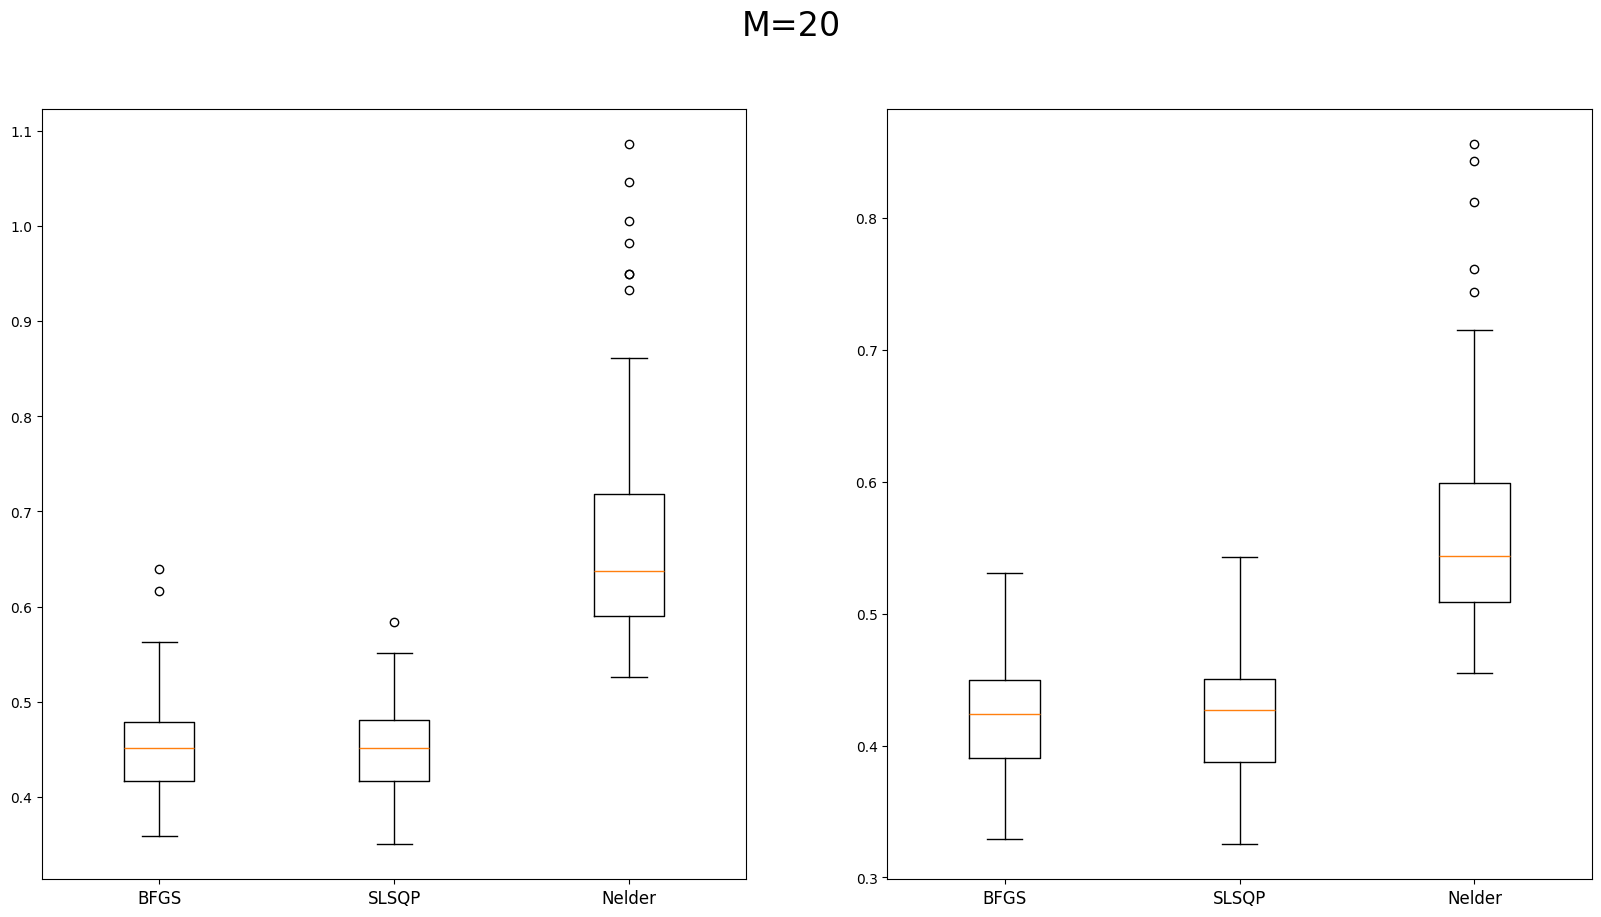

In [22]:
# run_timeを箱ひげ図でプロット
run_time_list_20_single = [
    twostage_single_BFGS_runtime_list_20,
    twostage_single_SLSQP_runtime_list_20,
    twostage_single_Neldar_runtime_list_20,
]

run_time_list_20_multi = [
    twostage_multi_BFGS_runtime_list_20,
    twostage_multi_SLSQP_runtime_list_20,
    twostage_multi_Neldar_runtime_list_20,
]

# グラフの作成
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 図全体のタイトルを設定
plt.suptitle("M=20", fontsize=24)

# 1つ目のグラフ
axs[0].boxplot(run_time_list_20_single)

axs[0].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# 2つ目のグラフ
axs[1].boxplot(run_time_list_20_multi)
axs[1].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# グラフの表示

plt.show()


In [23]:
# run_timeの平均を計算
run_time_list_20_single = [
    np.mean(twostage_single_BFGS_runtime_list_20),
    np.mean(twostage_single_SLSQP_runtime_list_20),
    np.mean(twostage_single_Neldar_runtime_list_20),
]

run_time_list_20_multi = [
    np.mean(twostage_multi_BFGS_runtime_list_20),
    np.mean(twostage_multi_SLSQP_runtime_list_20),
    np.mean(twostage_multi_Neldar_runtime_list_20),
]

# すべての結果をcsvファイルに保存
result_list_20 = (
    result_BFGS_list_20
    + result_SLSQP_list_20
    + result_Neldar_list_20
    + run_time_list_20_single
    + run_time_list_20_multi
)

result_list_20 = pd.DataFrame(result_list_20)
result_list_20.to_csv("result_list_20.csv")  # csvファイルに保存


In [24]:
# M = 30 で100回実験

# 結果を格納するリスト
predict_optimize_BFGS_value_list_30 = []

predict_optimize_SLSQP_value_list_30 = []

predict_optimize_Neldar_value_list_30 = []

sales_optimize_BFGS_value_list_30 = []

sales_optimize_SLSQP_value_list_30 = []

sales_optimize_Neldar_value_list_30 = []

po_prices_BFGS_list_30 = []
po_prices_SLSQP_list_30 = []
po_prices_Neldar_list_30 = []

twostage_single_BFGS_value_list_30 = []
twostage_single_BFGS_runtime_list_30 = []

twostage_single_SLSQP_value_list_30 = []
twostage_single_SLSQP_runtime_list_30 = []

twostage_single_Neldar_value_list_30 = []
twostage_single_Neldar_runtime_list_30 = []

ts_BFGS_list_30 = []
ts_SLSQP_list_30 = []
ts_Neldar_list_30 = []

twostage_multi_BFGS_value_list_30 = []
twostage_multi_BFGS_runtime_list_30 = []

twostage_multi_SLSQP_value_list_30 = []
twostage_multi_SLSQP_runtime_list_30 = []

twostage_multi_Neldar_value_list_30 = []
twostage_multi_Neldar_runtime_list_30 = []

tm_BFGS_list_30 = []
tm_SLSQP_list_30 = []
tm_Neldar_list_30 = []

M = 30
K = 5

for i in range(100):
    # データの生成
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    r_m = 0.6
    r_M = 1.0

    prices_list = []
    quantity_list = []

    for _ in range(500):
        prices = create_price(r_m, r_M, M)
        prices_list.append(prices)
        quantity = quantity_function(prices, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(prices_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # 予測と最適化を行う関数
    predict_optimize_BFGS_value, predict_optimize_BFGS_prices = predict_optimize_BFGS(M, X, y, z)
    predict_optimize_SLSQP_value, predict_optimize_SLSQP_prices = predict_optimize_SLSQP(
        M, X, y, z
    )
    predict_optimize_Neldar_value, predict_optimize_Neldar_prices = predict_optimize_Neldar(
        M, X, y, z
    )

    # 販売と最適化を行う関数
    sales_optimize_BFGS_value, sales_optimize_BFGS_prices = sales_optimize_BFGS(M, alpha, beta, z)
    sales_optimize_SLSQP_value, sales_optimize_SLSQP_prices = sales_optimize_SLSQP(
        M, alpha, beta, z
    )
    sales_optimize_Neldar_value, sales_optimize_Neldar_prices = sales_optimize_Neldar(
        M, alpha, beta, z
    )

    # 予測と最適化を行った価格をsales_functionに代入
    po_prices_BFGS = sum(sales_function(predict_optimize_BFGS_prices, alpha, beta))
    po_prices_SLSQP = sum(sales_function(predict_optimize_SLSQP_prices, alpha, beta))
    po_prices_Neldar = sum(sales_function(predict_optimize_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(single
    twostage_single_BFGS_prices, twostage_single_BFGS_value, twostage_single_BFGS_runtime = (
        twostage_single_BFGS(X, y, M, K, z)
    )
    twostage_single_SLSQP_prices, twostage_single_SLSQP_value, twostage_single_SLSQP_runtime = (
        twostage_single_SLSQP(X, y, M, K, z)
    )
    twostage_single_Neldar_prices, twostage_single_Neldar_value, twostage_single_Neldar_runtime = (
        twostage_single_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    ts_BFGS = sum(sales_function(twostage_single_BFGS_prices, alpha, beta))
    ts_SLSQP = sum(sales_function(twostage_single_SLSQP_prices, alpha, beta))
    ts_Neldar = sum(sales_function(twostage_single_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(multi)
    twostage_multi_BFGS_prices, twostage_multi_BFGS_value, twostage_multi_BFGS_runtime = (
        twostage_multi_BFGS(X, y, M, K, z)
    )
    twostage_multi_SLSQP_prices, twostage_multi_SLSQP_value, twostage_multi_SLSQP_runtime = (
        twostage_multi_SLSQP(X, y, M, K, z)
    )
    twostage_multi_Neldar_prices, twostage_multi_Neldar_value, twostage_multi_Neldar_runtime = (
        twostage_multi_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入

    tm_BFGS = sum(sales_function(twostage_multi_BFGS_prices, alpha, beta))
    tm_SLSQP = sum(sales_function(twostage_multi_SLSQP_prices, alpha, beta))
    tm_Neldar = sum(sales_function(twostage_multi_Neldar_prices, alpha, beta))

    # 結果を格納
    predict_optimize_BFGS_value_list_30.append(
        predict_optimize_BFGS_value / sales_optimize_BFGS_value
    )

    predict_optimize_SLSQP_value_list_30.append(
        predict_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    predict_optimize_Neldar_value_list_30.append(
        predict_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    sales_optimize_BFGS_value_list_30.append(sales_optimize_BFGS_value / sales_optimize_BFGS_value)

    sales_optimize_SLSQP_value_list_30.append(
        sales_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    sales_optimize_Neldar_value_list_30.append(
        sales_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    po_prices_BFGS_list_30.append(po_prices_BFGS / sales_optimize_BFGS_value)

    po_prices_SLSQP_list_30.append(po_prices_SLSQP / sales_optimize_SLSQP_value)

    po_prices_Neldar_list_30.append(po_prices_Neldar / sales_optimize_Neldar_value)

    twostage_single_BFGS_value_list_30.append(
        twostage_single_BFGS_value / sales_optimize_BFGS_value
    )

    twostage_single_BFGS_runtime_list_30.append(twostage_single_BFGS_runtime)

    twostage_single_SLSQP_value_list_30.append(
        twostage_single_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_single_SLSQP_runtime_list_30.append(twostage_single_SLSQP_runtime)

    twostage_single_Neldar_value_list_30.append(
        twostage_single_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_single_Neldar_runtime_list_30.append(twostage_single_Neldar_runtime)

    ts_BFGS_list_30.append(ts_BFGS / sales_optimize_BFGS_value)

    ts_SLSQP_list_30.append(ts_SLSQP / sales_optimize_SLSQP_value)

    ts_Neldar_list_30.append(ts_Neldar / sales_optimize_Neldar_value)

    twostage_multi_BFGS_value_list_30.append(twostage_multi_BFGS_value / sales_optimize_BFGS_value)

    twostage_multi_BFGS_runtime_list_30.append(twostage_multi_BFGS_runtime)

    twostage_multi_SLSQP_value_list_30.append(
        twostage_multi_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_multi_SLSQP_runtime_list_30.append(twostage_multi_SLSQP_runtime)

    twostage_multi_Neldar_value_list_30.append(
        twostage_multi_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_multi_Neldar_runtime_list_30.append(twostage_multi_Neldar_runtime)

    tm_BFGS_list_30.append(tm_BFGS / sales_optimize_BFGS_value)

    tm_Neldar_list_30.append(tm_Neldar / sales_optimize_Neldar_value)

    tm_SLSQP_list_30.append(tm_SLSQP / sales_optimize_SLSQP_value)


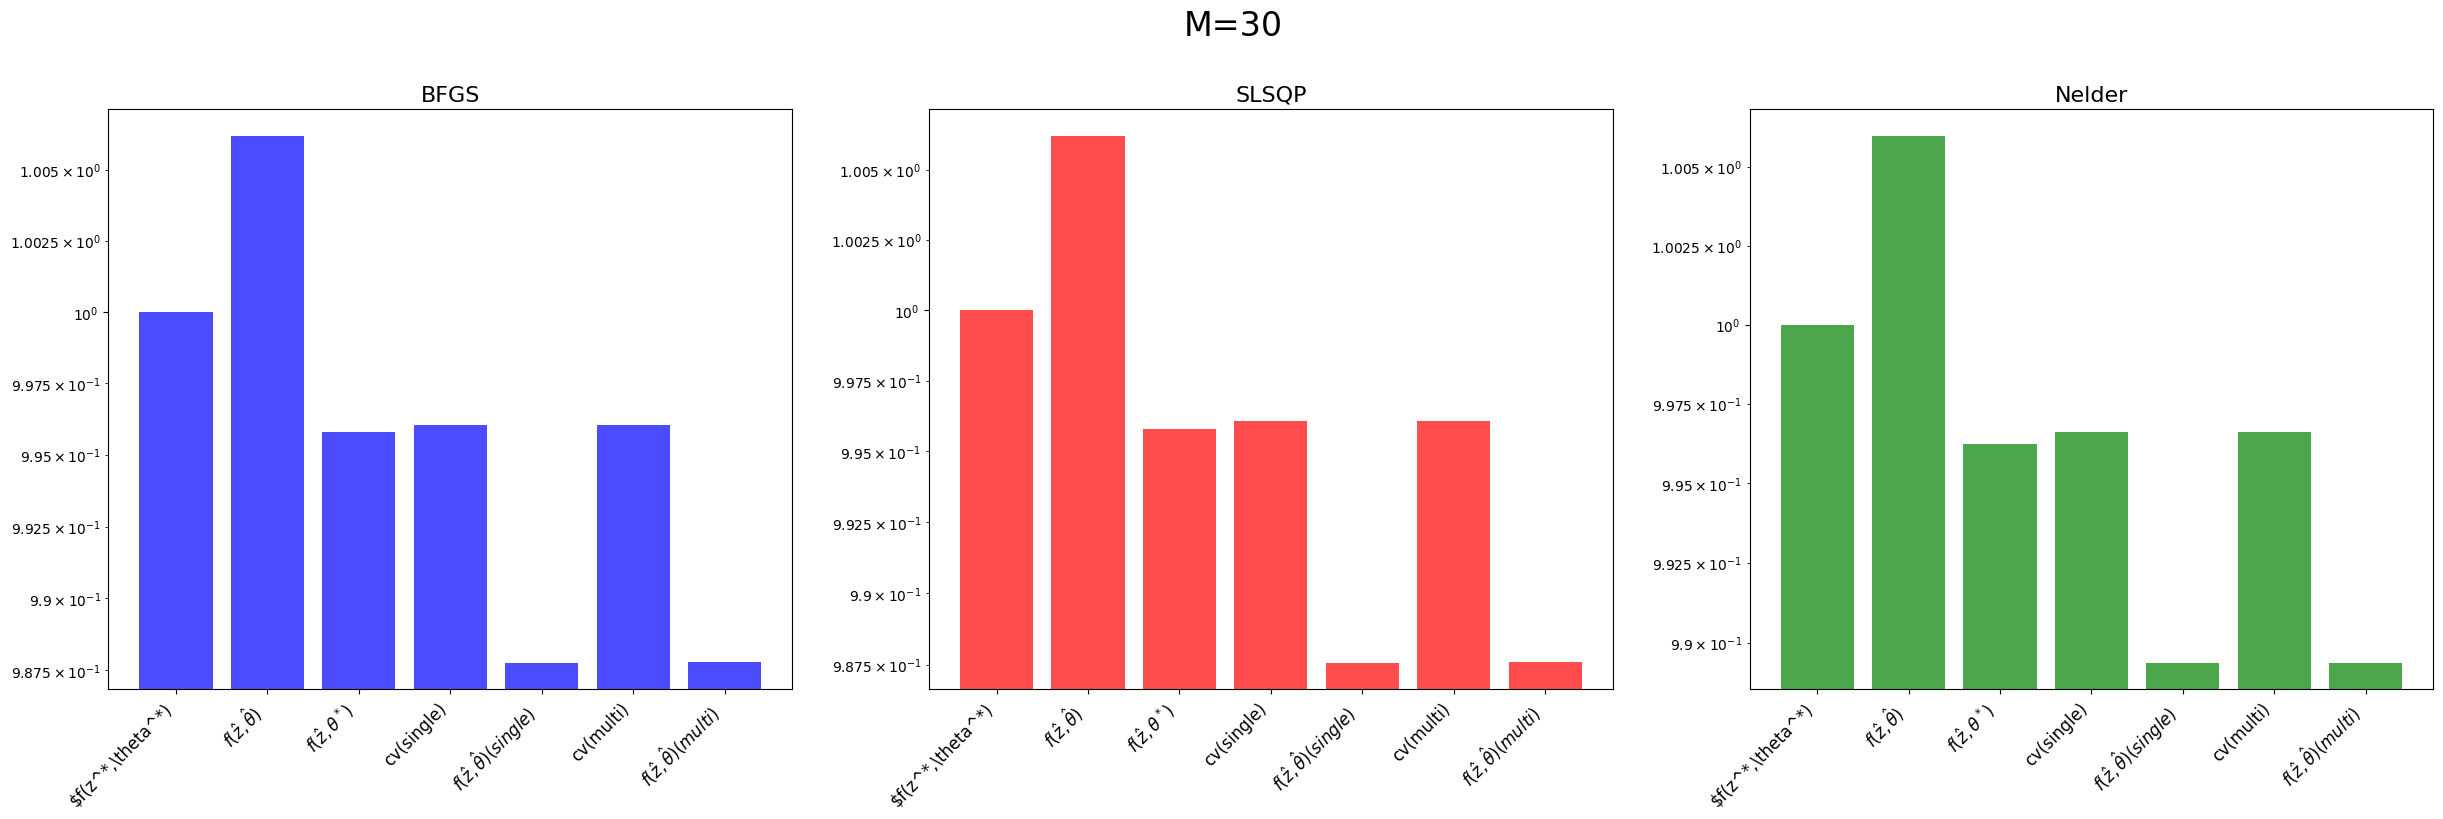

In [25]:
# BFGS
predict_optimize_BFGS_value_list_30 = np.mean(predict_optimize_BFGS_value_list_30)
sales_optimize_BFGS_value_list_30 = np.mean(sales_optimize_BFGS_value_list_30)
po_prices_BFGS_list_30 = np.mean(po_prices_BFGS_list_30)
twostage_single_BFGS_value_list_30 = np.mean(twostage_single_BFGS_value_list_30)
ts_BFGS_list_30 = np.mean(ts_BFGS_list_30)
twostage_multi_BFGS_value_list_30 = np.mean(twostage_multi_BFGS_value_list_30)
tm_BFGS_list_30 = np.mean(tm_BFGS_list_30)

# SLSQP
predict_optimize_SLSQP_value_list_30 = np.mean(predict_optimize_SLSQP_value_list_30)
sales_optimize_SLSQP_value_list_30 = np.mean(sales_optimize_SLSQP_value_list_30)
po_prices_SLSQP_list_30 = np.mean(po_prices_SLSQP_list_30)
twostage_single_SLSQP_value_list_30 = np.mean(twostage_single_SLSQP_value_list_30)
ts_SLSQP_list_30 = np.mean(ts_SLSQP_list_30)
twostage_multi_SLSQP_value_list_30 = np.mean(twostage_multi_SLSQP_value_list_30)
tm_SLSQP_list_30 = np.mean(tm_SLSQP_list_30)

# Neldar
predict_optimize_Neldar_value_list_30 = np.mean(predict_optimize_Neldar_value_list_30)
sales_optimize_Neldar_value_list_30 = np.mean(sales_optimize_Neldar_value_list_30)
po_prices_Neldar_list_30 = np.mean(po_prices_Neldar_list_30)
twostage_single_Neldar_value_list_30 = np.mean(twostage_single_Neldar_value_list_30)
ts_Neldar_list_30 = np.mean(ts_Neldar_list_30)
twostage_multi_Neldar_value_list_30 = np.mean(twostage_multi_Neldar_value_list_30)
tm_Neldar_list_30 = np.mean(tm_Neldar_list_30)

# 結果のリスト
result_BFGS_list_30 = [
    sales_optimize_BFGS_value_list_30,
    predict_optimize_BFGS_value_list_30,
    po_prices_BFGS_list_30,
    twostage_single_BFGS_value_list_30,
    ts_BFGS_list_30,
    twostage_multi_BFGS_value_list_30,
    tm_BFGS_list_30,
]

result_SLSQP_list_30 = [
    sales_optimize_SLSQP_value_list_30,
    predict_optimize_SLSQP_value_list_30,
    po_prices_SLSQP_list_30,
    twostage_single_SLSQP_value_list_30,
    ts_SLSQP_list_30,
    twostage_multi_SLSQP_value_list_30,
    tm_SLSQP_list_30,
]

result_Neldar_list_30 = [
    sales_optimize_Neldar_value_list_30,
    predict_optimize_Neldar_value_list_30,
    po_prices_Neldar_list_30,
    twostage_single_Neldar_value_list_30,
    ts_Neldar_list_30,
    twostage_multi_Neldar_value_list_30,
    tm_Neldar_list_30,
]

# ラベルの作成
labels = [
    r"$f(z^*,\theta^*)",
    r"$f(\hat{z},\hat{\theta})$",
    r"$f(\hat{z},\theta^*)$",
    "cv(single)",
    r"$f(\hat{z},\hat{\theta})(single)$",
    "cv(multi)",
    r"$f(\hat{z},\hat{\theta})(multi)$",
]

# x軸の位置を設定

x = np.arange(len(labels))  # 0から6までの整数

# 3つのサブプロットを持つ図を作成
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# 図全体のタイトルを設定
plt.suptitle("M=30", fontsize=24)

# BFGSの結果をプロット
axs[0].bar(x, result_BFGS_list_30, color="blue", alpha=0.7)
axs[0].set_title("BFGS", fontsize=16)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[0].set_yscale("log")

# SLSQPの結果をプロット
axs[1].bar(x, result_SLSQP_list_30, color="red", alpha=0.7)
axs[1].set_title("SLSQP", fontsize=16)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[1].set_yscale("log")

# Nelderの結果をプロット
axs[2].bar(x, result_Neldar_list_30, color="green", alpha=0.7)
axs[2].set_title("Nelder", fontsize=16)
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[2].set_yscale("log")

# レイアウトの調整
plt.subplots_adjust(bottom=0.3)  # 下

# グラフを表示
plt.show()


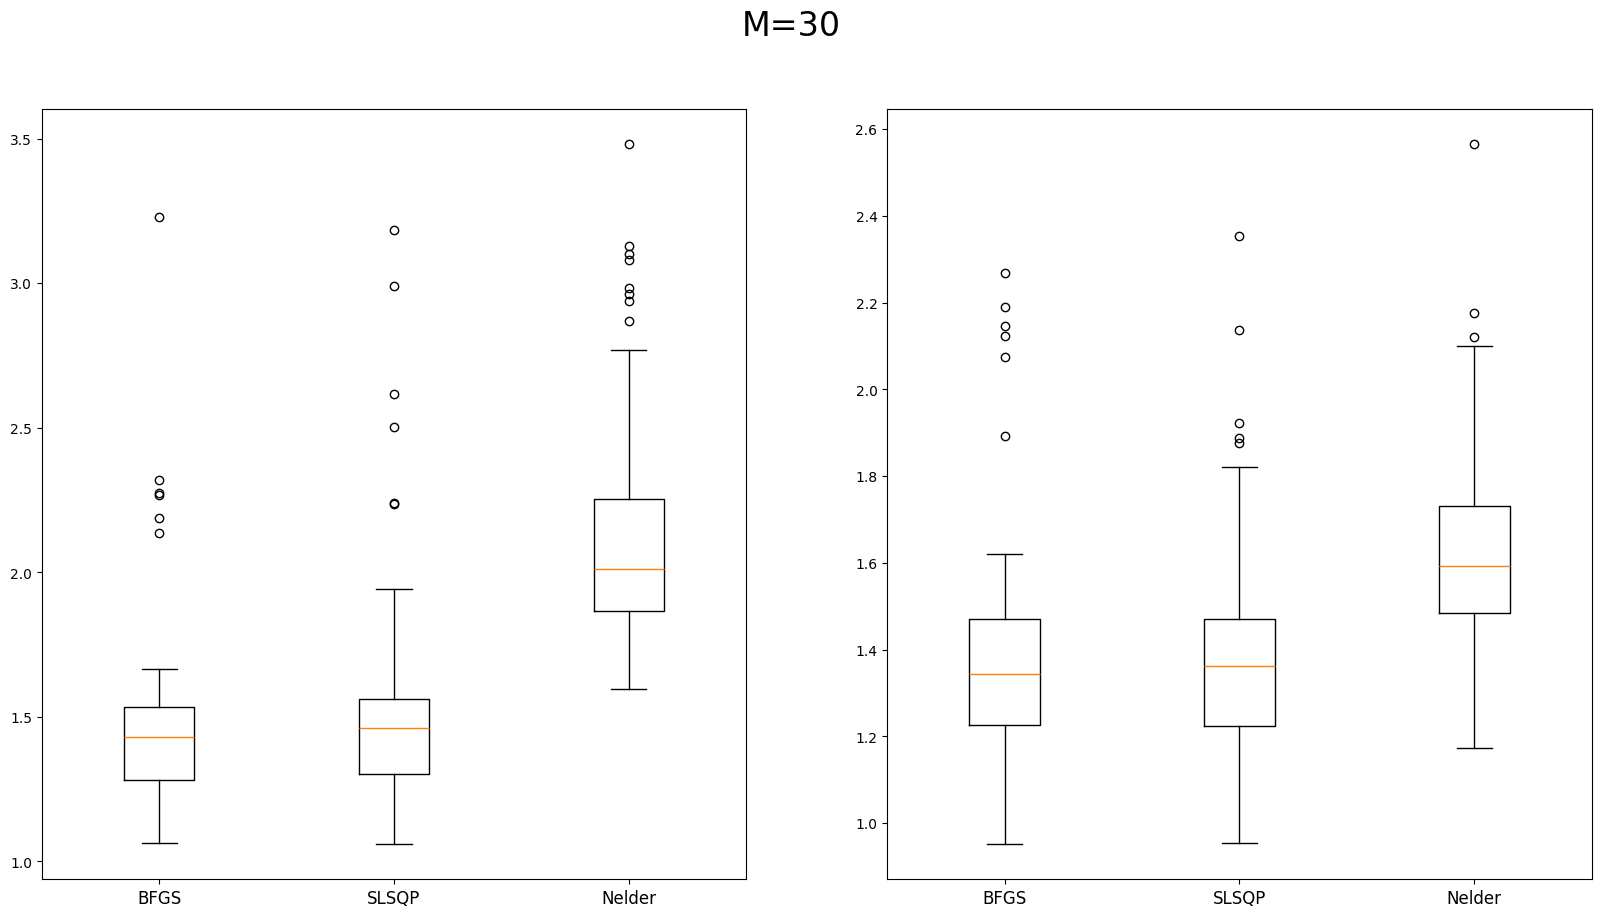

In [26]:
# run_timeを箱ひげ図でプロット
run_time_list_30_single = [
    twostage_single_BFGS_runtime_list_30,
    twostage_single_SLSQP_runtime_list_30,
    twostage_single_Neldar_runtime_list_30,
]

run_time_list_30_multi = [
    twostage_multi_BFGS_runtime_list_30,
    twostage_multi_SLSQP_runtime_list_30,
    twostage_multi_Neldar_runtime_list_30,
]

# グラフの作成
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 図全体のタイトルを設定
plt.suptitle("M=30", fontsize=24)

# 1つ目のグラフ
axs[0].boxplot(run_time_list_30_single)

axs[0].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# 2つ目のグラフ
axs[1].boxplot(run_time_list_30_multi)
axs[1].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# グラフの表示
plt.show()


In [27]:
# run_timeの平均を計算
run_time_list_30_single = [
    np.mean(twostage_single_BFGS_runtime_list_30),
    np.mean(twostage_single_SLSQP_runtime_list_30),
    np.mean(twostage_single_Neldar_runtime_list_30),
]

run_time_list_30_multi = [
    np.mean(twostage_multi_BFGS_runtime_list_30),
    np.mean(twostage_multi_SLSQP_runtime_list_30),
    np.mean(twostage_multi_Neldar_runtime_list_30),
]

# すべての結果をcsvファイルに保存
result_list_30 = (
    result_BFGS_list_30
    + result_SLSQP_list_30
    + result_Neldar_list_30
    + run_time_list_30_single
    + run_time_list_30_multi
)

result_list_30 = pd.DataFrame(result_list_30)
result_list_30.to_csv("result_list_30.csv")  # csvファイルに保存


In [28]:
# M = 40 で100回実験

# 結果を格納するリスト
predict_optimize_BFGS_value_list_40 = []

predict_optimize_SLSQP_value_list_40 = []

predict_optimize_Neldar_value_list_40 = []

sales_optimize_BFGS_value_list_40 = []

sales_optimize_SLSQP_value_list_40 = []

sales_optimize_Neldar_value_list_40 = []

po_prices_BFGS_list_40 = []
po_prices_SLSQP_list_40 = []
po_prices_Neldar_list_40 = []

twostage_single_BFGS_value_list_40 = []

twostage_single_BFGS_runtime_list_40 = []

twostage_single_SLSQP_value_list_40 = []

twostage_single_SLSQP_runtime_list_40 = []

twostage_single_Neldar_value_list_40 = []

twostage_single_Neldar_runtime_list_40 = []

ts_BFGS_list_40 = []
ts_SLSQP_list_40 = []
ts_Neldar_list_40 = []

twostage_multi_BFGS_value_list_40 = []

twostage_multi_BFGS_runtime_list_40 = []

twostage_multi_SLSQP_value_list_40 = []

twostage_multi_SLSQP_runtime_list_40 = []

twostage_multi_Neldar_value_list_40 = []

twostage_multi_Neldar_runtime_list_40 = []

tm_BFGS_list_40 = []
tm_SLSQP_list_40 = []
tm_Neldar_list_40 = []

M = 40
K = 5

for i in range(100):
    # データの生成
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    r_m = 0.6
    r_M = 1.0

    prices_list = []
    quantity_list = []

    for _ in range(500):
        prices = create_price(r_m, r_M, M)
        prices_list.append(prices)
        quantity = quantity_function(prices, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(prices_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # 予測と最適化を行う関数
    predict_optimize_BFGS_value, predict_optimize_BFGS_prices = predict_optimize_BFGS(M, X, y, z)
    predict_optimize_SLSQP_value, predict_optimize_SLSQP_prices = predict_optimize_SLSQP(
        M, X, y, z
    )
    predict_optimize_Neldar_value, predict_optimize_Neldar_prices = predict_optimize_Neldar(
        M, X, y, z
    )

    # 販売と最適化を行う関数
    sales_optimize_BFGS_value, sales_optimize_BFGS_prices = sales_optimize_BFGS(M, alpha, beta, z)
    sales_optimize_SLSQP_value, sales_optimize_SLSQP_prices = sales_optimize_SLSQP(
        M, alpha, beta, z
    )
    sales_optimize_Neldar_value, sales_optimize_Neldar_prices = sales_optimize_Neldar(
        M, alpha, beta, z
    )

    # 予測と最適化を行った価格をsales_functionに代入
    po_prices_BFGS = sum(sales_function(predict_optimize_BFGS_prices, alpha, beta))
    po_prices_SLSQP = sum(sales_function(predict_optimize_SLSQP_prices, alpha, beta))
    po_prices_Neldar = sum(sales_function(predict_optimize_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(single
    twostage_single_BFGS_prices, twostage_single_BFGS_value, twostage_single_BFGS_runtime = (
        twostage_single_BFGS(X, y, M, K, z)
    )
    twostage_single_SLSQP_prices, twostage_single_SLSQP_value, twostage_single_SLSQP_runtime = (
        twostage_single_SLSQP(X, y, M, K, z)
    )
    twostage_single_Neldar_prices, twostage_single_Neldar_value, twostage_single_Neldar_runtime = (
        twostage_single_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    ts_BFGS = sum(sales_function(twostage_single_BFGS_prices, alpha, beta))
    ts_SLSQP = sum(sales_function(twostage_single_SLSQP_prices, alpha, beta))
    ts_Neldar = sum(sales_function(twostage_single_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(multi)
    twostage_multi_BFGS_prices, twostage_multi_BFGS_value, twostage_multi_BFGS_runtime = (
        twostage_multi_BFGS(X, y, M, K, z)
    )

    twostage_multi_SLSQP_prices, twostage_multi_SLSQP_value, twostage_multi_SLSQP_runtime = (
        twostage_multi_SLSQP(X, y, M, K, z)
    )

    twostage_multi_Neldar_prices, twostage_multi_Neldar_value, twostage_multi_Neldar_runtime = (
        twostage_multi_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    tm_BFGS = sum(sales_function(twostage_multi_BFGS_prices, alpha, beta))
    tm_SLSQP = sum(sales_function(twostage_multi_SLSQP_prices, alpha, beta))
    tm_Neldar = sum(sales_function(twostage_multi_Neldar_prices, alpha, beta))

    # 結果を格納
    predict_optimize_BFGS_value_list_40.append(
        predict_optimize_BFGS_value / sales_optimize_BFGS_value
    )

    predict_optimize_SLSQP_value_list_40.append(
        predict_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    predict_optimize_Neldar_value_list_40.append(
        predict_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    sales_optimize_BFGS_value_list_40.append(sales_optimize_BFGS_value / sales_optimize_BFGS_value)

    sales_optimize_SLSQP_value_list_40.append(
        sales_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    sales_optimize_Neldar_value_list_40.append(
        sales_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    po_prices_BFGS_list_40.append(po_prices_BFGS / sales_optimize_BFGS_value)

    po_prices_SLSQP_list_40.append(po_prices_SLSQP / sales_optimize_SLSQP_value)

    po_prices_Neldar_list_40.append(po_prices_Neldar / sales_optimize_Neldar_value)

    twostage_single_BFGS_value_list_40.append(
        twostage_single_BFGS_value / sales_optimize_BFGS_value
    )

    twostage_single_BFGS_runtime_list_40.append(twostage_single_BFGS_runtime)

    twostage_single_SLSQP_value_list_40.append(
        twostage_single_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_single_SLSQP_runtime_list_40.append(twostage_single_SLSQP_runtime)

    twostage_single_Neldar_value_list_40.append(
        twostage_single_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_single_Neldar_runtime_list_40.append(twostage_single_Neldar_runtime)

    ts_BFGS_list_40.append(ts_BFGS / sales_optimize_BFGS_value)

    ts_SLSQP_list_40.append(ts_SLSQP / sales_optimize_SLSQP_value)

    ts_Neldar_list_40.append(ts_Neldar / sales_optimize_Neldar_value)

    twostage_multi_BFGS_value_list_40.append(twostage_multi_BFGS_value / sales_optimize_BFGS_value)

    twostage_multi_BFGS_runtime_list_40.append(twostage_multi_BFGS_runtime)

    twostage_multi_SLSQP_value_list_40.append(
        twostage_multi_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_multi_SLSQP_runtime_list_40.append(twostage_multi_SLSQP_runtime)

    twostage_multi_Neldar_value_list_40.append(
        twostage_multi_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_multi_Neldar_runtime_list_40.append(twostage_multi_Neldar_runtime)

    tm_BFGS_list_40.append(tm_BFGS / sales_optimize_BFGS_value)

    tm_Neldar_list_40.append(tm_Neldar / sales_optimize_Neldar_value)

    tm_SLSQP_list_40.append(tm_SLSQP / sales_optimize_SLSQP_value)


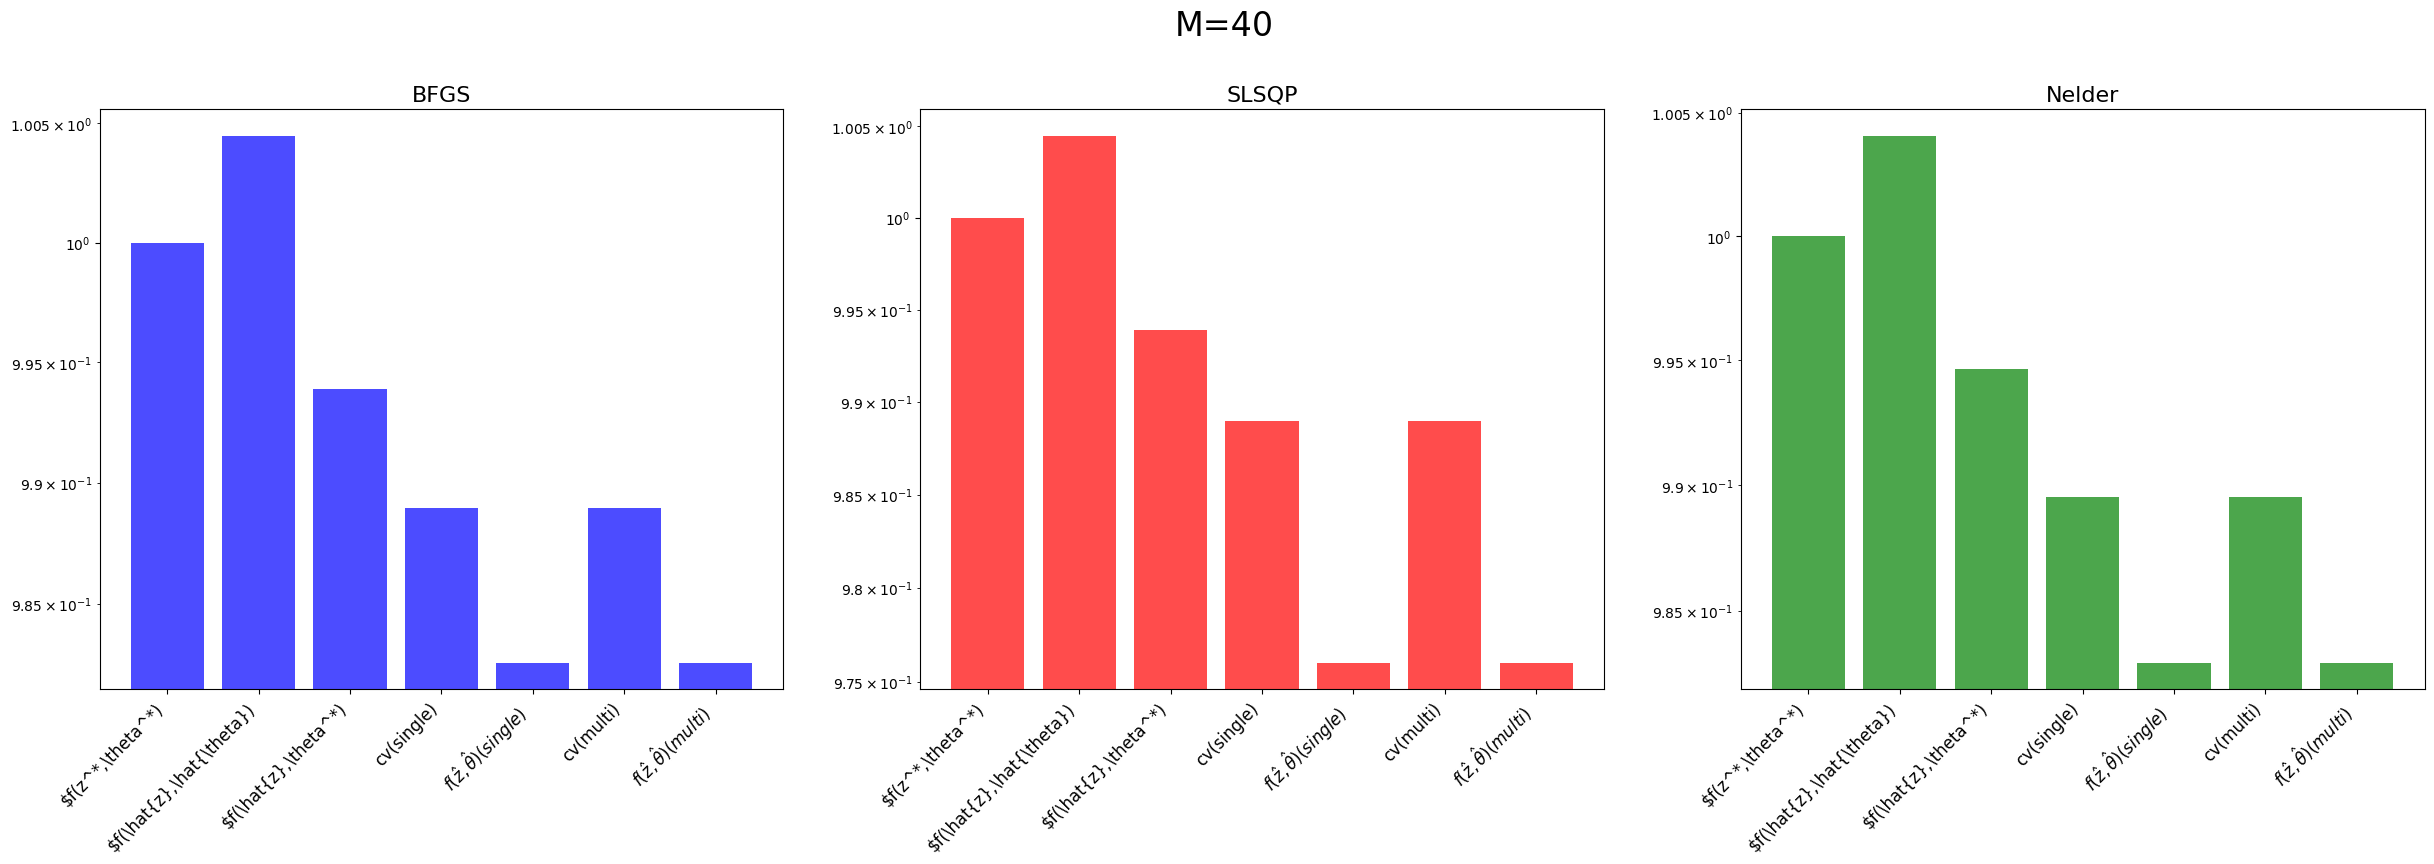

In [29]:
# BFGS
predict_optimize_BFGS_value_list_40 = np.mean(predict_optimize_BFGS_value_list_40)
sales_optimize_BFGS_value_list_40 = np.mean(sales_optimize_BFGS_value_list_40)
po_prices_BFGS_list_40 = np.mean(po_prices_BFGS_list_40)
twostage_single_BFGS_value_list_40 = np.mean(twostage_single_BFGS_value_list_40)
ts_BFGS_list_40 = np.mean(ts_BFGS_list_40)
twostage_multi_BFGS_value_list_40 = np.mean(twostage_multi_BFGS_value_list_40)
tm_BFGS_list_40 = np.mean(tm_BFGS_list_40)

# SLSQP
predict_optimize_SLSQP_value_list_40 = np.mean(predict_optimize_SLSQP_value_list_40)
sales_optimize_SLSQP_value_list_40 = np.mean(sales_optimize_SLSQP_value_list_40)
po_prices_SLSQP_list_40 = np.mean(po_prices_SLSQP_list_40)
twostage_single_SLSQP_value_list_40 = np.mean(twostage_single_SLSQP_value_list_40)
ts_SLSQP_list_40 = np.mean(ts_SLSQP_list_40)
twostage_multi_SLSQP_value_list_40 = np.mean(twostage_multi_SLSQP_value_list_40)
tm_SLSQP_list_40 = np.mean(tm_SLSQP_list_40)

# Neldar
predict_optimize_Neldar_value_list_40 = np.mean(predict_optimize_Neldar_value_list_40)
sales_optimize_Neldar_value_list_40 = np.mean(sales_optimize_Neldar_value_list_40)
po_prices_Neldar_list_40 = np.mean(po_prices_Neldar_list_40)
twostage_single_Neldar_value_list_40 = np.mean(twostage_single_Neldar_value_list_40)
ts_Neldar_list_40 = np.mean(ts_Neldar_list_40)
twostage_multi_Neldar_value_list_40 = np.mean(twostage_multi_Neldar_value_list_40)
tm_Neldar_list_40 = np.mean(tm_Neldar_list_40)

# 結果のリスト
result_BFGS_list_40 = [
    sales_optimize_BFGS_value_list_40,
    predict_optimize_BFGS_value_list_40,
    po_prices_BFGS_list_40,
    twostage_single_BFGS_value_list_40,
    ts_BFGS_list_40,
    twostage_multi_BFGS_value_list_40,
    tm_BFGS_list_40,
]

result_SLSQP_list_40 = [
    sales_optimize_SLSQP_value_list_40,
    predict_optimize_SLSQP_value_list_40,
    po_prices_SLSQP_list_40,
    twostage_single_SLSQP_value_list_40,
    ts_SLSQP_list_40,
    twostage_multi_SLSQP_value_list_40,
    tm_SLSQP_list_40,
]

result_Neldar_list_40 = [
    sales_optimize_Neldar_value_list_40,
    predict_optimize_Neldar_value_list_40,
    po_prices_Neldar_list_40,
    twostage_single_Neldar_value_list_40,
    ts_Neldar_list_40,
    twostage_multi_Neldar_value_list_40,
    tm_Neldar_list_40,
]

# ラベルの作成
labels = [
    r"$f(z^*,\theta^*)",
    r"$f(\hat{z},\hat{\theta})",
    r"$f(\hat{z},\theta^*)",
    "cv(single)",
    r"$f(\hat{z},\hat{\theta})(single)$",
    "cv(multi)",
    r"$f(\hat{z},\hat{\theta})(multi)$",
]

# x軸の位置を設定

x = np.arange(len(labels))  # 0から6までの整数

# 3つのサブプロットを持つ図を作成
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# 図全体のタイトルを設定
plt.suptitle("M=40", fontsize=24)

# BFGSの結果をプロット
axs[0].bar(x, result_BFGS_list_40, color="blue", alpha=0.7)
axs[0].set_title("BFGS", fontsize=16)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[0].set_yscale("log")

# SLSQPの結果をプロット
axs[1].bar(x, result_SLSQP_list_40, color="red", alpha=0.7)
axs[1].set_title("SLSQP", fontsize=16)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[1].set_yscale("log")

# Nelderの結果をプロット
axs[2].bar(x, result_Neldar_list_40, color="green", alpha=0.7)
axs[2].set_title("Nelder", fontsize=16)
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
axs[2].set_yscale("log")

# レイアウトの調整
plt.subplots_adjust(bottom=0.3)  # 下

# グラフを表示
plt.show()


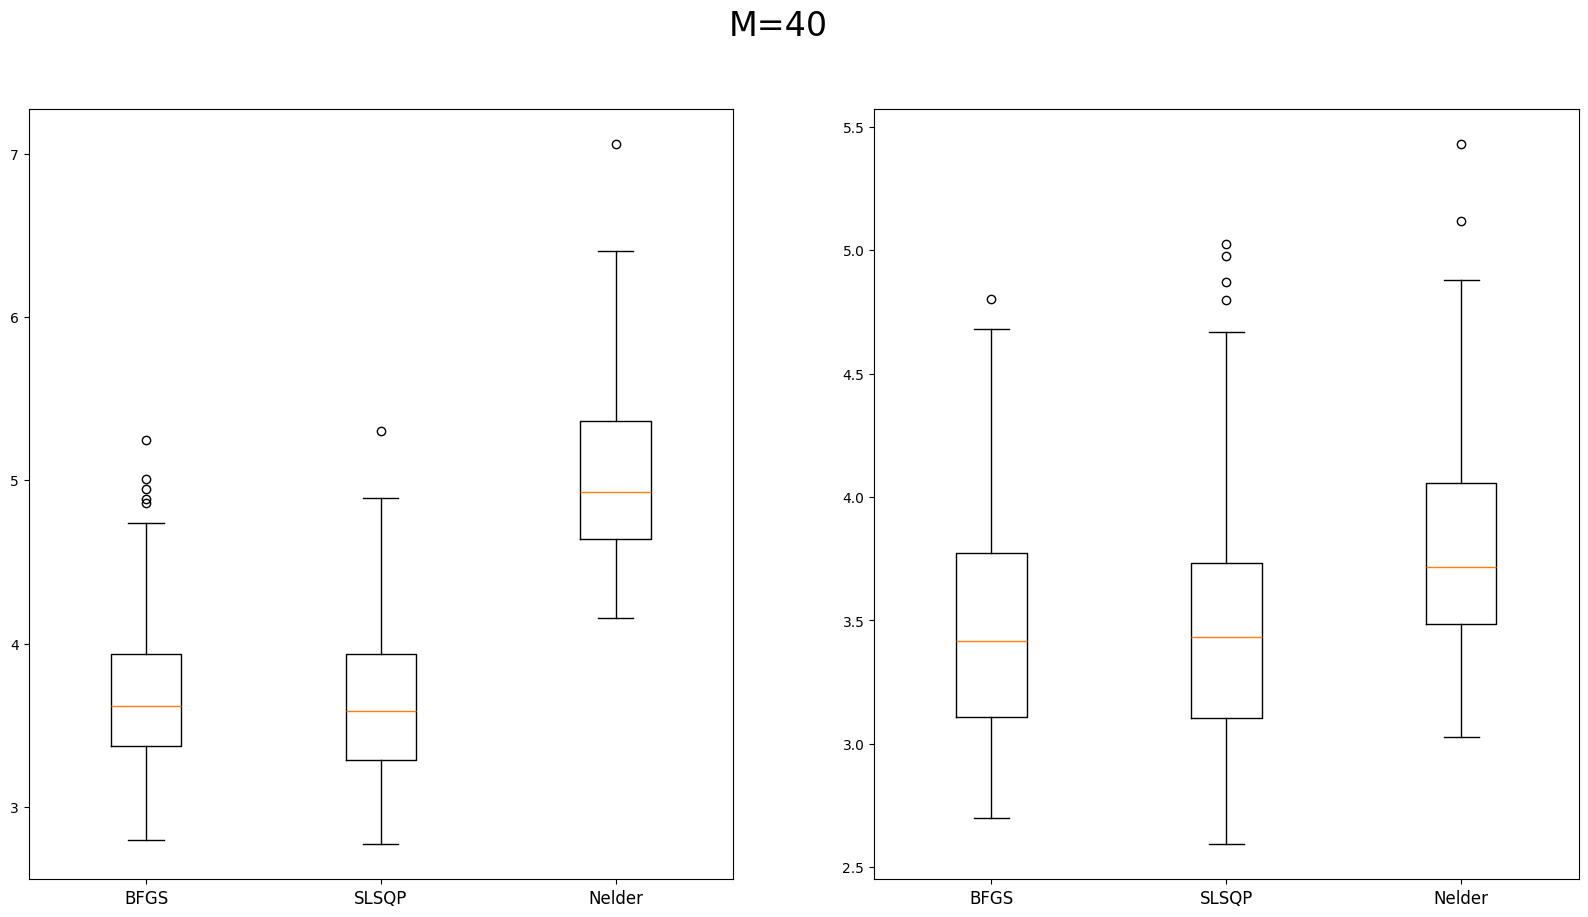

In [30]:
# run_timeを箱ひげ図でプロット
run_time_list_40_single = [
    twostage_single_BFGS_runtime_list_40,
    twostage_single_SLSQP_runtime_list_40,
    twostage_single_Neldar_runtime_list_40,
]

run_time_list_40_multi = [
    twostage_multi_BFGS_runtime_list_40,
    twostage_multi_SLSQP_runtime_list_40,
    twostage_multi_Neldar_runtime_list_40,
]

# グラフの作成
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 図全体のタイトルを設定
plt.suptitle("M=40", fontsize=24)

# 1つ目のグラフ
axs[0].boxplot(run_time_list_40_single)

axs[0].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# 2つ目のグラフ

axs[1].boxplot(run_time_list_40_multi)

axs[1].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# グラフの表示
plt.show()


In [31]:
# run_timeの平均を計算
run_time_list_40_single = [
    np.mean(twostage_single_BFGS_runtime_list_40),
    np.mean(twostage_single_SLSQP_runtime_list_40),
    np.mean(twostage_single_Neldar_runtime_list_40),
]

run_time_list_40_multi = [
    np.mean(twostage_multi_BFGS_runtime_list_40),
    np.mean(twostage_multi_SLSQP_runtime_list_40),
    np.mean(twostage_multi_Neldar_runtime_list_40),
]

# すべての結果をcsvファイルに保存
result_list_40 = (
    result_BFGS_list_40
    + result_SLSQP_list_40
    + result_Neldar_list_40
    + run_time_list_40_single
    + run_time_list_40_multi
)

result_list_40 = pd.DataFrame(result_list_40)


result_list_40.to_csv("result_list_40.csv")  # csvファイルに保存


In [32]:
# M = 50 で100回実験

# 結果を格納するリスト
predict_optimize_BFGS_value_list_50 = []

predict_optimize_SLSQP_value_list_50 = []

predict_optimize_Neldar_value_list_50 = []

sales_optimize_BFGS_value_list_50 = []

sales_optimize_SLSQP_value_list_50 = []

sales_optimize_Neldar_value_list_50 = []

po_prices_BFGS_list_50 = []

po_prices_SLSQP_list_50 = []

po_prices_Neldar_list_50 = []

twostage_single_BFGS_value_list_50 = []

twostage_single_BFGS_runtime_list_50 = []

twostage_single_SLSQP_value_list_50 = []

twostage_single_SLSQP_runtime_list_50 = []

twostage_single_Neldar_value_list_50 = []

twostage_single_Neldar_runtime_list_50 = []

ts_BFGS_list_50 = []

ts_SLSQP_list_50 = []

ts_Neldar_list_50 = []

twostage_multi_BFGS_value_list_50 = []

twostage_multi_BFGS_runtime_list_50 = []

twostage_multi_SLSQP_value_list_50 = []

twostage_multi_SLSQP_runtime_list_50 = []

twostage_multi_Neldar_value_list_50 = []

twostage_multi_Neldar_runtime_list_50 = []

tm_BFGS_list_50 = []

tm_SLSQP_list_50 = []

tm_Neldar_list_50 = []

M = 50
K = 5

for i in range(100):
    # データの生成
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    r_m = 0.6
    r_M = 1.0

    prices_list = []
    quantity_list = []

    for _ in range(500):
        prices = create_price(r_m, r_M, M)
        prices_list.append(prices)
        quantity = quantity_function(prices, alpha, beta)
        quantity_list.append(quantity)

    X = np.array(prices_list).astype(float)
    y = np.array(quantity_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # 予測と最適化を行う関数
    predict_optimize_BFGS_value, predict_optimize_BFGS_prices = predict_optimize_BFGS(M, X, y, z)
    predict_optimize_SLSQP_value, predict_optimize_SLSQP_prices = predict_optimize_SLSQP(
        M, X, y, z
    )
    predict_optimize_Neldar_value, predict_optimize_Neldar_prices = predict_optimize_Neldar(
        M, X, y, z
    )

    # 販売と最適化を行う関数
    sales_optimize_BFGS_value, sales_optimize_BFGS_prices = sales_optimize_BFGS(M, alpha, beta, z)
    sales_optimize_SLSQP_value, sales_optimize_SLSQP_prices = sales_optimize_SLSQP(
        M, alpha, beta, z
    )
    sales_optimize_Neldar_value, sales_optimize_Neldar_prices = sales_optimize_Neldar(
        M, alpha, beta, z
    )

    # 予測と最適化を行った価格をsales_functionに代入
    po_prices_BFGS = sum(sales_function(predict_optimize_BFGS_prices, alpha, beta))
    po_prices_SLSQP = sum(sales_function(predict_optimize_SLSQP_prices, alpha, beta))
    po_prices_Neldar = sum(sales_function(predict_optimize_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(single
    twostage_single_BFGS_prices, twostage_single_BFGS_value, twostage_single_BFGS_runtime = (
        twostage_single_BFGS(X, y, M, K, z)
    )
    twostage_single_SLSQP_prices, twostage_single_SLSQP_value, twostage_single_SLSQP_runtime = (
        twostage_single_SLSQP(X, y, M, K, z)
    )
    twostage_single_Neldar_prices, twostage_single_Neldar_value, twostage_single_Neldar_runtime = (
        twostage_single_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    ts_BFGS = sum(sales_function(twostage_single_BFGS_prices, alpha, beta))
    ts_SLSQP = sum(sales_function(twostage_single_SLSQP_prices, alpha, beta))
    ts_Neldar = sum(sales_function(twostage_single_Neldar_prices, alpha, beta))

    # 2段階最適化を行う関数(multi)
    twostage_multi_BFGS_prices, twostage_multi_BFGS_value, twostage_multi_BFGS_runtime = (
        twostage_multi_BFGS(X, y, M, K, z)
    )

    twostage_multi_SLSQP_prices, twostage_multi_SLSQP_value, twostage_multi_SLSQP_runtime = (
        twostage_multi_SLSQP(X, y, M, K, z)
    )

    twostage_multi_Neldar_prices, twostage_multi_Neldar_value, twostage_multi_Neldar_runtime = (
        twostage_multi_Neldar(X, y, M, K, z)
    )

    # 2段階最適化を行った価格をsales_functionに代入
    tm_BFGS = sum(sales_function(twostage_multi_BFGS_prices, alpha, beta))
    tm_SLSQP = sum(sales_function(twostage_multi_SLSQP_prices, alpha, beta))
    tm_Neldar = sum(sales_function(twostage_multi_Neldar_prices, alpha, beta))

    # 結果を格納
    predict_optimize_BFGS_value_list_50.append(
        predict_optimize_BFGS_value / sales_optimize_BFGS_value
    )

    predict_optimize_SLSQP_value_list_50.append(
        predict_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    predict_optimize_Neldar_value_list_50.append(
        predict_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    sales_optimize_BFGS_value_list_50.append(sales_optimize_BFGS_value / sales_optimize_BFGS_value)

    sales_optimize_SLSQP_value_list_50.append(
        sales_optimize_SLSQP_value / sales_optimize_SLSQP_value
    )

    sales_optimize_Neldar_value_list_50.append(
        sales_optimize_Neldar_value / sales_optimize_Neldar_value
    )

    po_prices_BFGS_list_50.append(po_prices_BFGS / sales_optimize_BFGS_value)

    po_prices_SLSQP_list_50.append(po_prices_SLSQP / sales_optimize_SLSQP_value)

    po_prices_Neldar_list_50.append(po_prices_Neldar / sales_optimize_Neldar_value)

    twostage_single_BFGS_value_list_50.append(
        twostage_single_BFGS_value / sales_optimize_BFGS_value
    )

    twostage_single_BFGS_runtime_list_50.append(twostage_single_BFGS_runtime)

    twostage_single_SLSQP_value_list_50.append(
        twostage_single_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_single_SLSQP_runtime_list_50.append(twostage_single_SLSQP_runtime)

    twostage_single_Neldar_value_list_50.append(
        twostage_single_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_single_Neldar_runtime_list_50.append(twostage_single_Neldar_runtime)

    ts_BFGS_list_50.append(ts_BFGS / sales_optimize_BFGS_value)

    ts_SLSQP_list_50.append(ts_SLSQP / sales_optimize_SLSQP_value)

    ts_Neldar_list_50.append(ts_Neldar / sales_optimize_Neldar_value)

    twostage_multi_BFGS_value_list_50.append(twostage_multi_BFGS_value / sales_optimize_BFGS_value)

    twostage_multi_BFGS_runtime_list_50.append(twostage_multi_BFGS_runtime)

    twostage_multi_SLSQP_value_list_50.append(
        twostage_multi_SLSQP_value / sales_optimize_SLSQP_value
    )

    twostage_multi_SLSQP_runtime_list_50.append(twostage_multi_SLSQP_runtime)

    twostage_multi_Neldar_value_list_50.append(
        twostage_multi_Neldar_value / sales_optimize_Neldar_value
    )

    twostage_multi_Neldar_runtime_list_50.append(twostage_multi_Neldar_runtime)

    tm_BFGS_list_50.append(tm_BFGS / sales_optimize_BFGS_value)

    tm_Neldar_list_50.append(tm_Neldar / sales_optimize_Neldar_value)

    tm_SLSQP_list_50.append(tm_SLSQP / sales_optimize_SLSQP_value)


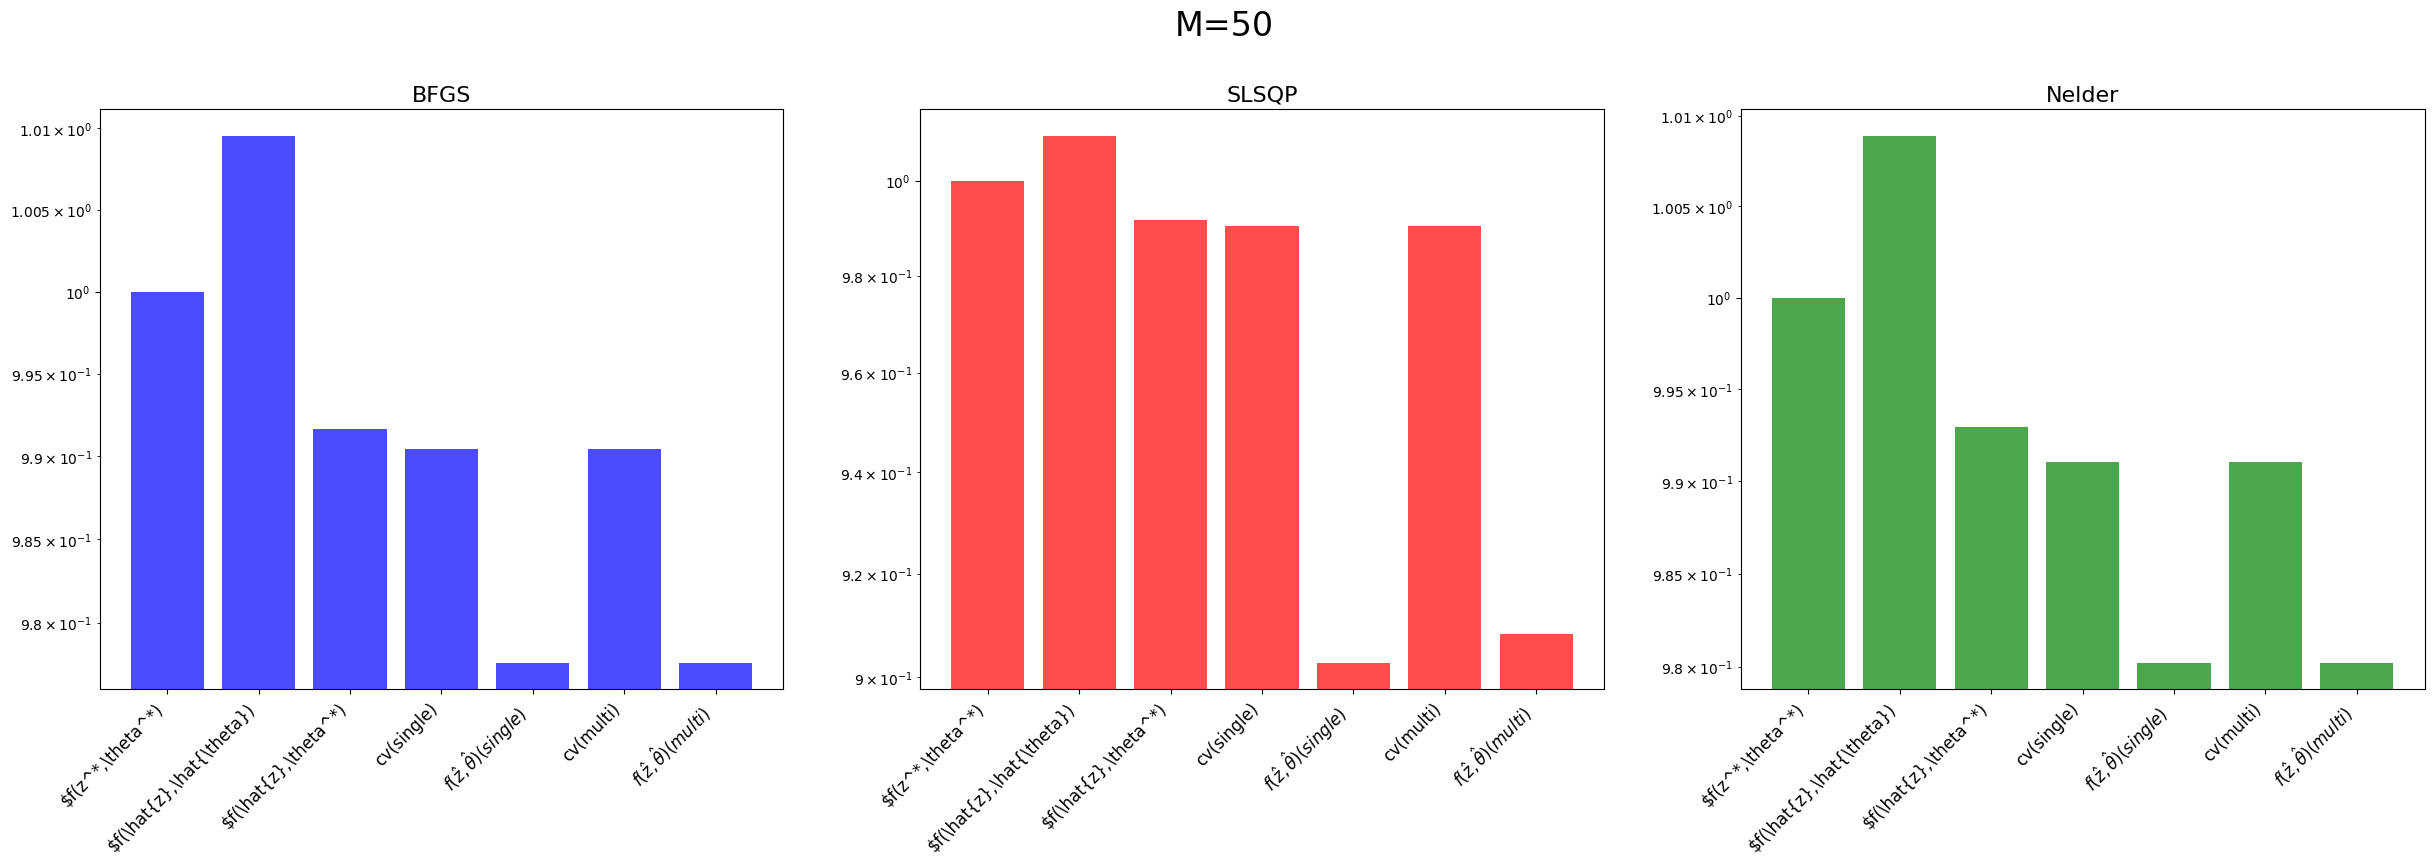

In [33]:
# BFGS
predict_optimize_BFGS_value_list_50 = np.mean(predict_optimize_BFGS_value_list_50)
sales_optimize_BFGS_value_list_50 = np.mean(sales_optimize_BFGS_value_list_50)
po_prices_BFGS_list_50 = np.mean(po_prices_BFGS_list_50)
twostage_single_BFGS_value_list_50 = np.mean(twostage_single_BFGS_value_list_50)
ts_BFGS_list_50 = np.mean(ts_BFGS_list_50)
twostage_multi_BFGS_value_list_50 = np.mean(twostage_multi_BFGS_value_list_50)
tm_BFGS_list_50 = np.mean(tm_BFGS_list_50)

# SLSQP
predict_optimize_SLSQP_value_list_50 = np.mean(predict_optimize_SLSQP_value_list_50)
sales_optimize_SLSQP_value_list_50 = np.mean(sales_optimize_SLSQP_value_list_50)
po_prices_SLSQP_list_50 = np.mean(po_prices_SLSQP_list_50)
twostage_single_SLSQP_value_list_50 = np.mean(twostage_single_SLSQP_value_list_50)
ts_SLSQP_list_50 = np.mean(ts_SLSQP_list_50)
twostage_multi_SLSQP_value_list_50 = np.mean(twostage_multi_SLSQP_value_list_50)
tm_SLSQP_list_50 = np.mean(tm_SLSQP_list_50)

# Neldar
predict_optimize_Neldar_value_list_50 = np.mean(predict_optimize_Neldar_value_list_50)
sales_optimize_Neldar_value_list_50 = np.mean(sales_optimize_Neldar_value_list_50)
po_prices_Neldar_list_50 = np.mean(po_prices_Neldar_list_50)
twostage_single_Neldar_value_list_50 = np.mean(twostage_single_Neldar_value_list_50)
ts_Neldar_list_50 = np.mean(ts_Neldar_list_50)
twostage_multi_Neldar_value_list_50 = np.mean(twostage_multi_Neldar_value_list_50)
tm_Neldar_list_50 = np.mean(tm_Neldar_list_50)

# 結果のリスト
result_BFGS_list_50 = [
    sales_optimize_BFGS_value_list_50,
    predict_optimize_BFGS_value_list_50,
    po_prices_BFGS_list_50,
    twostage_single_BFGS_value_list_50,
    ts_BFGS_list_50,
    twostage_multi_BFGS_value_list_50,
    tm_BFGS_list_50,
]


result_SLSQP_list_50 = [
    sales_optimize_SLSQP_value_list_50,
    predict_optimize_SLSQP_value_list_50,
    po_prices_SLSQP_list_50,
    twostage_single_SLSQP_value_list_50,
    ts_SLSQP_list_50,
    twostage_multi_SLSQP_value_list_50,
    tm_SLSQP_list_50,
]

result_Neldar_list_50 = [
    sales_optimize_Neldar_value_list_50,
    predict_optimize_Neldar_value_list_50,
    po_prices_Neldar_list_50,
    twostage_single_Neldar_value_list_50,
    ts_Neldar_list_50,
    twostage_multi_Neldar_value_list_50,
    tm_Neldar_list_50,
]

# ラベルの作成
labels = [
    r"$f(z^*,\theta^*)",
    r"$f(\hat{z},\hat{\theta})",
    r"$f(\hat{z},\theta^*)",
    "cv(single)",
    r"$f(\hat{z},\hat{\theta})(single)$",
    "cv(multi)",
    r"$f(\hat{z},\hat{\theta})(multi)$",
]

# x軸の位置を設定

x = np.arange(len(labels))  # 0から6までの整数

# 3つのサブプロットを持つ図を作成

fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# 図全体のタイトルを設定

plt.suptitle("M=50", fontsize=24)

# BFGSの結果をプロット

axs[0].bar(x, result_BFGS_list_50, color="blue", alpha=0.7)

axs[0].set_title("BFGS", fontsize=16)

axs[0].set_xticks(x)

axs[0].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)

axs[0].set_yscale("log")

# SLSQPの結果をプロット

axs[1].bar(x, result_SLSQP_list_50, color="red", alpha=0.7)

axs[1].set_title("SLSQP", fontsize=16)

axs[1].set_xticks(x)

axs[1].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)

axs[1].set_yscale("log")

# Nelderの結果をプロット

axs[2].bar(x, result_Neldar_list_50, color="green", alpha=0.7)

axs[2].set_title("Nelder", fontsize=16)

axs[2].set_xticks(x)

axs[2].set_xticklabels(labels, rotation=45, ha="right", fontsize=12)

axs[2].set_yscale("log")

# レイアウトの調整

plt.subplots_adjust(bottom=0.3)  # 下

# グラフを表示

plt.show()


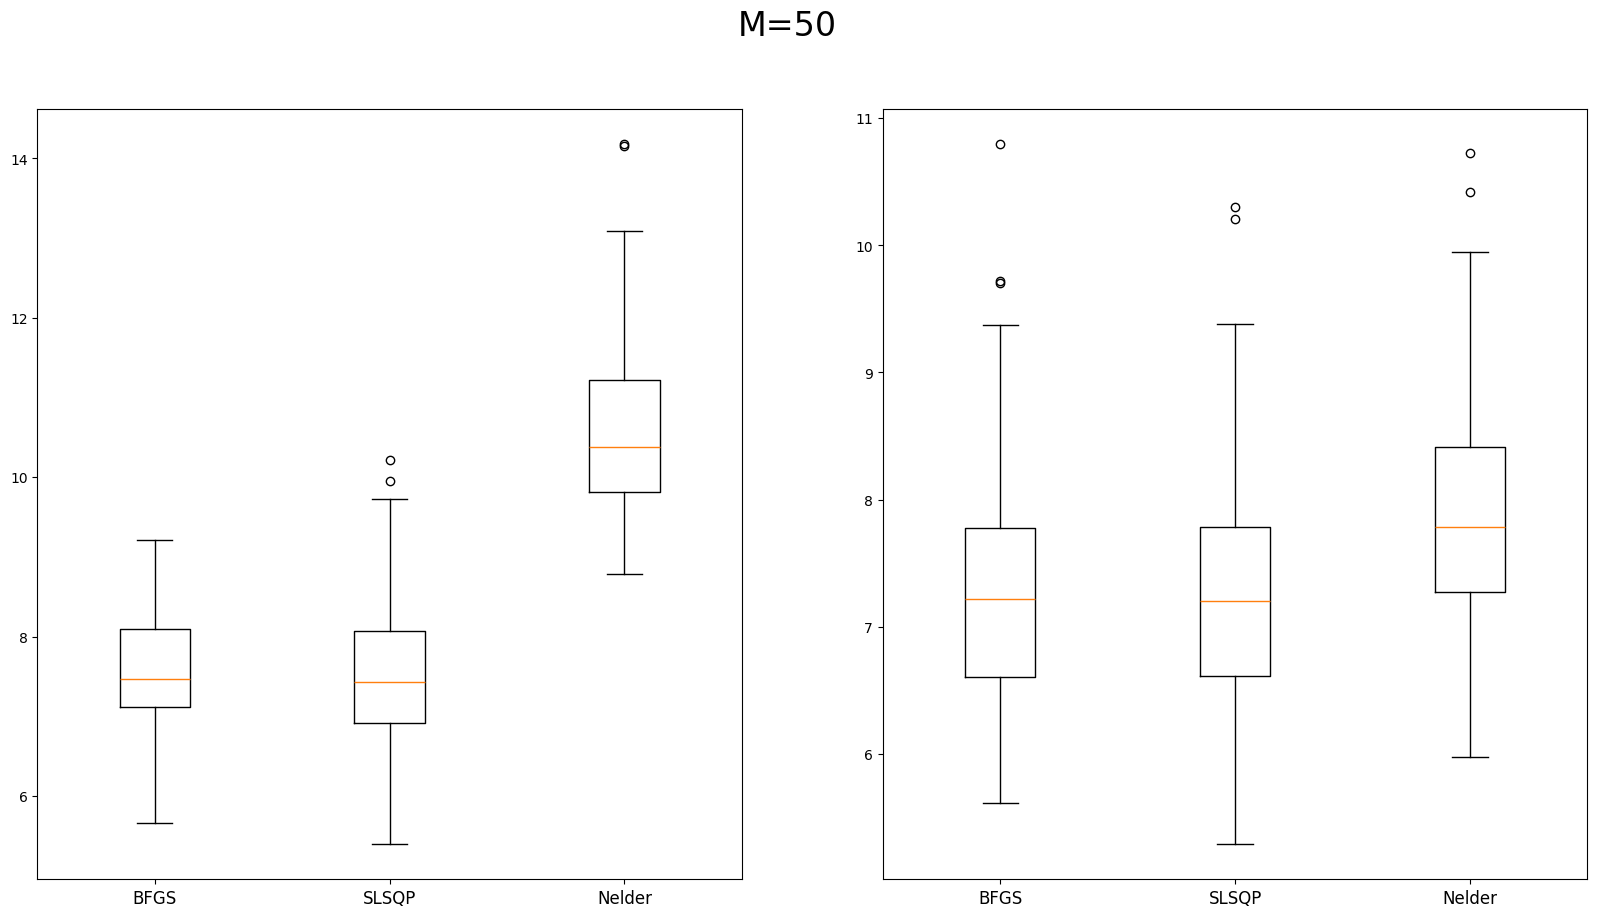

In [34]:
# run_timeを箱ひげ図でプロット
run_time_list_50_single = [
    twostage_single_BFGS_runtime_list_50,
    twostage_single_SLSQP_runtime_list_50,
    twostage_single_Neldar_runtime_list_50,
]

run_time_list_50_multi = [
    twostage_multi_BFGS_runtime_list_50,
    twostage_multi_SLSQP_runtime_list_50,
    twostage_multi_Neldar_runtime_list_50,
]

# グラフの作成

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 図全体のタイトルを設定

plt.suptitle("M=50", fontsize=24)

# 1つ目のグラフ

axs[0].boxplot(run_time_list_50_single)

axs[0].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# 2つ目のグラフ

axs[1].boxplot(run_time_list_50_multi)

axs[1].set_xticklabels(["BFGS", "SLSQP", "Nelder"], fontsize=12)

# グラフの表示

plt.show()


In [35]:
# run_timeの平均を計算
run_time_list_50_single = [
    np.mean(twostage_single_BFGS_runtime_list_50),
    np.mean(twostage_single_SLSQP_runtime_list_50),
    np.mean(twostage_single_Neldar_runtime_list_50),
]

run_time_list_50_multi = [
    np.mean(twostage_multi_BFGS_runtime_list_50),
    np.mean(twostage_multi_SLSQP_runtime_list_50),
    np.mean(twostage_multi_Neldar_runtime_list_50),
]

# すべての結果をcsvファイルに保存
result_list_50 = (
    result_BFGS_list_50
    + result_SLSQP_list_50
    + result_Neldar_list_50
    + run_time_list_50_single
    + run_time_list_50_multi
)

result_list_50 = pd.DataFrame(result_list_50)

result_list_50.to_csv("result_list_50.csv")  # csvファイルに保存
